## Applied ML for baseball:

#### By Thomas Maxence Franco 
Submitted to the Faculty of Science in partial fulfillment of the requirements for the degree of 
#### Master of Modeling for Science and Engineering 
at the 
#### UNIVERSITAT AUTÒNOMA DE BARCELONA 
Directed by 
Tomás Manuel Margalef Burrull
July 2024

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from itertools import combinations
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

In [2]:
file_path = "C:\\Users\\mfran\\OneDrive - UAB\\Masters\\Thesis\\Pitching\\adv\\Dataframes\\advperfpitch_all.csv"

try:
    df = pd.read_csv(file_path, encoding='latin1')
except UnicodeDecodeError:
    print("Error reading the file with 'latin1' encoding.")
    
df.head()

,Name,year,AAV,minor_league,SP,RP,Yrs,W,L,ERA,...,SIERA,xERA,EV,FIP_2,WAR_2,xFIP_2,WPA_2,SIERA_2,xERA_2,EV_2
0,Shohei Ohtani,2024,34.877193,False,True,False,6,10,5,3.136364,...,3.663228,3.82,86.378451,2.401588,5.598513,2.651803,3.405847,2.733153,2.68,87.126312
1,Sonny Gray,2024,25.000000,False,True,False,11,8,8,1.790000,...,3.949935,3.66,89.132116,3.404910,2.360812,3.657305,0.810078,3.731328,3.67,88.050132
2,Brandon Woodruff,2024,8.750000,False,True,False,7,5,1,2.283582,...,3.445838,2.82,89.024346,3.079822,3.554962,3.137087,2.104717,3.025599,3.15,88.674631
3,Aaron Nola,2024,24.571429,False,True,False,9,12,9,4.460000,...,3.751155,3.71,89.281106,2.580724,6.312604,2.769559,2.400706,2.802457,2.74,87.699850
4,Clayton Kershaw,2024,5.000000,False,True,False,16,13,5,2.460000,...,3.817126,3.77,89.026886,2.566257,3.849776,2.826209,2.550616,2.982783,2.51,87.098630


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 67 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          508 non-null    object 
 1   year          508 non-null    int64  
 2   AAV           508 non-null    float64
 3   minor_league  508 non-null    bool   
 4   SP            508 non-null    bool   
 5   RP            508 non-null    bool   
 6   Yrs           508 non-null    int64  
 7   W             508 non-null    int64  
 8   L             508 non-null    int64  
 9   ERA           508 non-null    float64
 10  WHIP          508 non-null    float64
 11  G             508 non-null    int64  
 12  GS            508 non-null    int64  
 13  QS            508 non-null    int64  
 14  SV            508 non-null    int64  
 15  BS            508 non-null    int64  
 16  HLD           508 non-null    int64  
 17  IP            508 non-null    float64
 18  SO            508 non-null    

On a previous step (in Excel) I created a few additional variables like Acc_G, VeloChange, Avg K/9, among others. The ones with Acc as a prefix are the sum of the same statistic in the two seasons. For example G + G_2 = Acc_G. 

For VeloChange I wanted to see the change in average mph thrown from one season to another. This will refelct if the pitcher is throwing faster or slower and we will see if teams pay attention to that. 

For the other variables with the suffix "Change" the thought process was the same. It will reflect the improvement (or otherwise) of the pitcher. 

### Handling the NULL values. 

In [4]:
columns = ['FIP', 'WAR', 'xFIP', 'WPA','SIERA', 'xERA', 'EV']

for column in columns:
    column_2 = f"{column}_2"
    
    df.loc[df[column_2].isnull() & df[column].notnull(), column_2] = df.loc[df[column_2].isnull() & df[column].notnull(), column]

    median_value = df[column].median()
    df.loc[df[column].isnull() & df[column_2].notnull(), column] = median_value

In [5]:
df.head()

,Name,year,AAV,minor_league,SP,RP,Yrs,W,L,ERA,...,SIERA,xERA,EV,FIP_2,WAR_2,xFIP_2,WPA_2,SIERA_2,xERA_2,EV_2
0,Shohei Ohtani,2024,34.877193,False,True,False,6,10,5,3.136364,...,3.663228,3.82,86.378451,2.401588,5.598513,2.651803,3.405847,2.733153,2.68,87.126312
1,Sonny Gray,2024,25.000000,False,True,False,11,8,8,1.790000,...,3.949935,3.66,89.132116,3.404910,2.360812,3.657305,0.810078,3.731328,3.67,88.050132
2,Brandon Woodruff,2024,8.750000,False,True,False,7,5,1,2.283582,...,3.445838,2.82,89.024346,3.079822,3.554962,3.137087,2.104717,3.025599,3.15,88.674631
3,Aaron Nola,2024,24.571429,False,True,False,9,12,9,4.460000,...,3.751155,3.71,89.281106,2.580724,6.312604,2.769559,2.400706,2.802457,2.74,87.699850
4,Clayton Kershaw,2024,5.000000,False,True,False,16,13,5,2.460000,...,3.817126,3.77,89.026886,2.566257,3.849776,2.826209,2.550616,2.982783,2.51,87.098630


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 67 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          508 non-null    object 
 1   year          508 non-null    int64  
 2   AAV           508 non-null    float64
 3   minor_league  508 non-null    bool   
 4   SP            508 non-null    bool   
 5   RP            508 non-null    bool   
 6   Yrs           508 non-null    int64  
 7   W             508 non-null    int64  
 8   L             508 non-null    int64  
 9   ERA           508 non-null    float64
 10  WHIP          508 non-null    float64
 11  G             508 non-null    int64  
 12  GS            508 non-null    int64  
 13  QS            508 non-null    int64  
 14  SV            508 non-null    int64  
 15  BS            508 non-null    int64  
 16  HLD           508 non-null    int64  
 17  IP            508 non-null    float64
 18  SO            508 non-null    

In [7]:
df['Acc_WAR'] = df['WAR'] + df['WAR_2']

df.head()

,Name,year,AAV,minor_league,SP,RP,Yrs,W,L,ERA,...,xERA,EV,FIP_2,WAR_2,xFIP_2,WPA_2,SIERA_2,xERA_2,EV_2,Acc_WAR
0,Shohei Ohtani,2024,34.877193,False,True,False,6,10,5,3.136364,...,3.82,86.378451,2.401588,5.598513,2.651803,3.405847,2.733153,2.68,87.126312,7.966784
1,Sonny Gray,2024,25.000000,False,True,False,11,8,8,1.790000,...,3.66,89.132116,3.404910,2.360812,3.657305,0.810078,3.731328,3.67,88.050132,7.645342
2,Brandon Woodruff,2024,8.750000,False,True,False,7,5,1,2.283582,...,2.82,89.024346,3.079822,3.554962,3.137087,2.104717,3.025599,3.15,88.674631,5.001775
3,Aaron Nola,2024,24.571429,False,True,False,9,12,9,4.460000,...,3.71,89.281106,2.580724,6.312604,2.769559,2.400706,2.802457,2.74,87.699850,10.192750
4,Clayton Kershaw,2024,5.000000,False,True,False,16,13,5,2.460000,...,3.77,89.026886,2.566257,3.849776,2.826209,2.550616,2.982783,2.51,87.098630,6.191165


In [8]:
df['Acc_WPA'] = df['WPA'] + df['WPA_2']

df.head()

,Name,year,AAV,minor_league,SP,RP,Yrs,W,L,ERA,...,EV,FIP_2,WAR_2,xFIP_2,WPA_2,SIERA_2,xERA_2,EV_2,Acc_WAR,Acc_WPA
0,Shohei Ohtani,2024,34.877193,False,True,False,6,10,5,3.136364,...,86.378451,2.401588,5.598513,2.651803,3.405847,2.733153,2.68,87.126312,7.966784,5.364157
1,Sonny Gray,2024,25.000000,False,True,False,11,8,8,1.790000,...,89.132116,3.404910,2.360812,3.657305,0.810078,3.731328,3.67,88.050132,7.645342,3.818644
2,Brandon Woodruff,2024,8.750000,False,True,False,7,5,1,2.283582,...,89.024346,3.079822,3.554962,3.137087,2.104717,3.025599,3.15,88.674631,5.001775,3.346239
3,Aaron Nola,2024,24.571429,False,True,False,9,12,9,4.460000,...,89.281106,2.580724,6.312604,2.769559,2.400706,2.802457,2.74,87.699850,10.192750,2.951880
4,Clayton Kershaw,2024,5.000000,False,True,False,16,13,5,2.460000,...,89.026886,2.566257,3.849776,2.826209,2.550616,2.982783,2.51,87.098630,6.191165,4.462551


## Feature Selection

In [9]:
removed_columns = ['PlayerId', 'year']
used_columns = df.columns[~df.columns.isin(removed_columns)]

df2 = df.drop(columns=removed_columns).copy()

df2.head()

,Name,AAV,minor_league,SP,RP,Yrs,W,L,ERA,WHIP,...,EV,FIP_2,WAR_2,xFIP_2,WPA_2,SIERA_2,xERA_2,EV_2,Acc_WAR,Acc_WPA
0,Shohei Ohtani,34.877193,False,True,False,6,10,5,3.136364,1.060606,...,86.378451,2.401588,5.598513,2.651803,3.405847,2.733153,2.68,87.126312,7.966784,5.364157
1,Sonny Gray,25.000000,False,True,False,11,8,8,1.790000,1.150000,...,89.132116,3.404910,2.360812,3.657305,0.810078,3.731328,3.67,88.050132,7.645342,3.818644
2,Brandon Woodruff,8.750000,False,True,False,7,5,1,2.283582,0.820896,...,89.024346,3.079822,3.554962,3.137087,2.104717,3.025599,3.15,88.674631,5.001775,3.346239
3,Aaron Nola,24.571429,False,True,False,9,12,9,4.460000,1.150000,...,89.281106,2.580724,6.312604,2.769559,2.400706,2.802457,2.74,87.699850,10.192750,2.951880
4,Clayton Kershaw,5.000000,False,True,False,16,13,5,2.460000,1.060000,...,89.026886,2.566257,3.849776,2.826209,2.550616,2.982783,2.51,87.098630,6.191165,4.462551


### Correlation Matrix

In [10]:
numerical_columns = df2.select_dtypes(include=['number']).columns
boolean_columns = df2.select_dtypes(include=['bool']).columns

selected_columns = numerical_columns.union(boolean_columns)

correlation_matrix = df2[selected_columns].corr()

correlation_matrix.style.background_gradient("coolwarm", vmin=-1, vmax=1)

,AAV,Acc_BS,Acc_G,Acc_GS,Acc_HLD,Acc_IP,Acc_QS,Acc_SO,Acc_SV,Acc_WAR,Acc_WPA,BB/9,BB/9Change,BB/9_2,BS,BS_2,ERA,ERAChange,ERA_2,EV,EV_2,FBv,FBv_2,FIP,FIP_2,G,GS,GS_2,G_2,HLD,HLD_2,HR/9,HR/9Change,HR/9_2,IP,IP_2,K/9,K/9Change,K/9_2,L,L_2,QS,QS_2,RP,SIERA,SIERA_2,SO,SO_2,SP,SV,SV_2,VeloChange,W,WAR,WAR_2,WHIP,WHIP_2,WPA,WPA_2,W_2,Yrs,minor_league,xERA,xERA_2,xFIP,xFIP_2
AAV,1.000000,-0.141774,-0.126680,0.481221,-0.231492,0.520056,0.588713,0.699078,0.109195,0.833589,0.536313,-0.233117,-0.055092,-0.186281,-0.093451,-0.157158,-0.268117,-0.122536,-0.139335,-0.065243,-0.047599,0.113450,0.157481,-0.342961,-0.230013,-0.055656,0.519264,0.374161,-0.164019,-0.164574,-0.237728,-0.140803,-0.079534,-0.029122,0.571719,0.314843,0.305915,0.020352,0.283678,0.310883,0.228153,0.642682,0.417008,-0.503318,-0.324951,-0.252234,0.720249,0.496335,0.408327,0.137674,0.068189,0.102403,0.621211,0.792543,0.630495,-0.331762,-0.226860,0.522665,0.311268,0.377868,0.146390,-0.351841,-0.316110,-0.184885,-0.437135,-0.347564
Acc_BS,-0.141774,1.000000,0.812708,-0.634561,0.616946,-0.410425,-0.566434,-0.298466,0.633576,-0.237913,0.192244,0.146751,0.083055,0.062090,0.883594,0.889483,-0.125227,0.066524,-0.250117,-0.108704,-0.128376,-0.020287,0.300204,-0.127850,-0.266038,0.702755,-0.570479,-0.605002,0.719721,0.560144,0.518228,-0.091571,0.071300,-0.182483,-0.340680,-0.354653,0.291783,-0.060503,0.349334,-0.222667,-0.220568,-0.484358,-0.525610,0.526251,-0.279831,-0.399019,-0.257121,-0.260068,-0.638076,0.557238,0.603441,-0.041506,-0.265322,-0.232426,-0.173673,-0.107750,-0.199297,0.104805,0.194086,-0.263054,-0.002054,-0.040098,-0.229198,-0.301249,-0.107119,-0.234637
Acc_G,-0.126680,0.812708,1.000000,-0.582224,0.753202,-0.279932,-0.507681,-0.179002,0.527385,-0.180348,0.276683,0.101128,0.030352,0.073450,0.711320,0.729511,-0.202499,0.045021,-0.310926,-0.163542,-0.190928,-0.027393,0.223850,-0.189869,-0.289734,0.870062,-0.523876,-0.554664,0.880433,0.673839,0.642186,-0.152845,0.054407,-0.218708,-0.235752,-0.238637,0.274215,-0.060196,0.331589,-0.184301,-0.185113,-0.432414,-0.472673,0.545955,-0.319330,-0.424798,-0.149673,-0.160305,-0.653245,0.479207,0.489085,-0.043223,-0.227657,-0.172050,-0.135822,-0.166929,-0.226370,0.183001,0.247187,-0.205963,0.056540,-0.088472,-0.289357,-0.350144,-0.154328,-0.250672
Acc_GS,0.481221,-0.634561,-0.582224,1.000000,-0.601443,0.907760,0.939304,0.817930,-0.366382,0.619242,-0.064570,-0.171970,-0.017526,-0.163786,-0.531575,-0.592849,0.091363,-0.011623,0.127290,0.095128,0.102142,0.058908,-0.238489,0.125400,0.140331,-0.493388,0.924731,0.928294,-0.525290,-0.528124,-0.522234,0.156057,-0.010720,0.163709,0.797598,0.742041,-0.214121,-0.041212,-0.171981,0.666432,0.631833,0.829081,0.847583,-0.772785,0.285694,0.285029,0.702931,0.714320,0.854608,-0.314119,-0.355939,0.075794,0.674827,0.523887,0.533733,0.034571,0.034934,-0.037466,-0.062926,0.680238,0.143710,-0.250167,0.197667,0.168238,0.080207,0.078280
Acc_HLD,-0.231492,0.616946,0.753202,-0.601443,1.000000,-0.402688,-0.539657,-0.342750,0.071809,-0.268268,0.178701,0.081621,-0.004294,0.092122,0.520482,0.572817,-0.154758,0.026855,-0.226331,-0.170430,-0.189569,-0.023972,0.150271,-0.162727,-0.225954,0.644909,-0.543221,-0.570969,0.673170,0.865747,0.880019,-0.146655,0.060236,-0.220529,-0.345263,-0.337395,0.212162,0.017294,0.193608,-0.285006,-0.293425,-0.461621,-0.500614,0.488927,-0.268454,-0.300231,-0.291173,-0.302570,-0.588694,0.075846,0.057480,-0.034603,-0.315886,-0.230521,-0.227633,-0.131620,-0.141316,0.133717,0.144134,-0.305982,-0.008491,-0.010688,-0.236169,-0.240106,-0.126094,-0.165554
Acc_IP,0.520056,-0.410425,-0.279932,0.907760,-0.402688,1.000000,0.899327,0.878631,-0.211825,0.668107,0.050438,-0.183798,-0.006622,-0.188862,-0.323258,-0.403507,0.019992,0.004671,0.017067,0.042356,0.037553,0.054952,-0.208084,0.061379,0.026663,-0.222325,0.840654,0.841476,-0.266887,-0.338316,-0.364157,0.116713,0.020278,0.084823,0.840641,0.853954,-0.154101,-0.068418,-0.085575,0.677465,0.649765,0.795062,0.810333,-0.657816,0.190785,0.148103,0.753

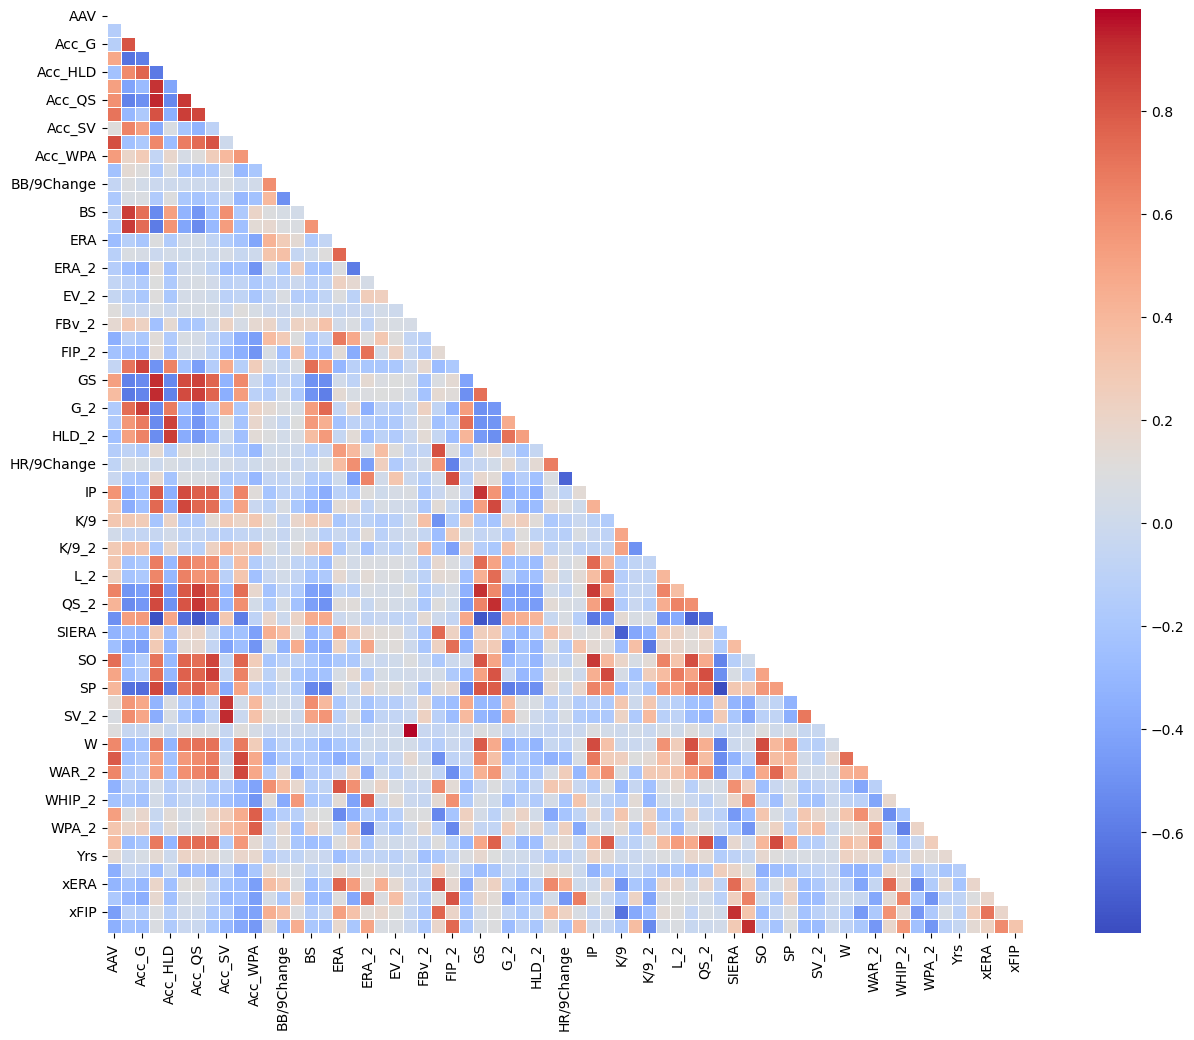

In [11]:
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(15, 12))


sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', fmt='.2f', linewidths=.5, ax=ax)

plt.show()

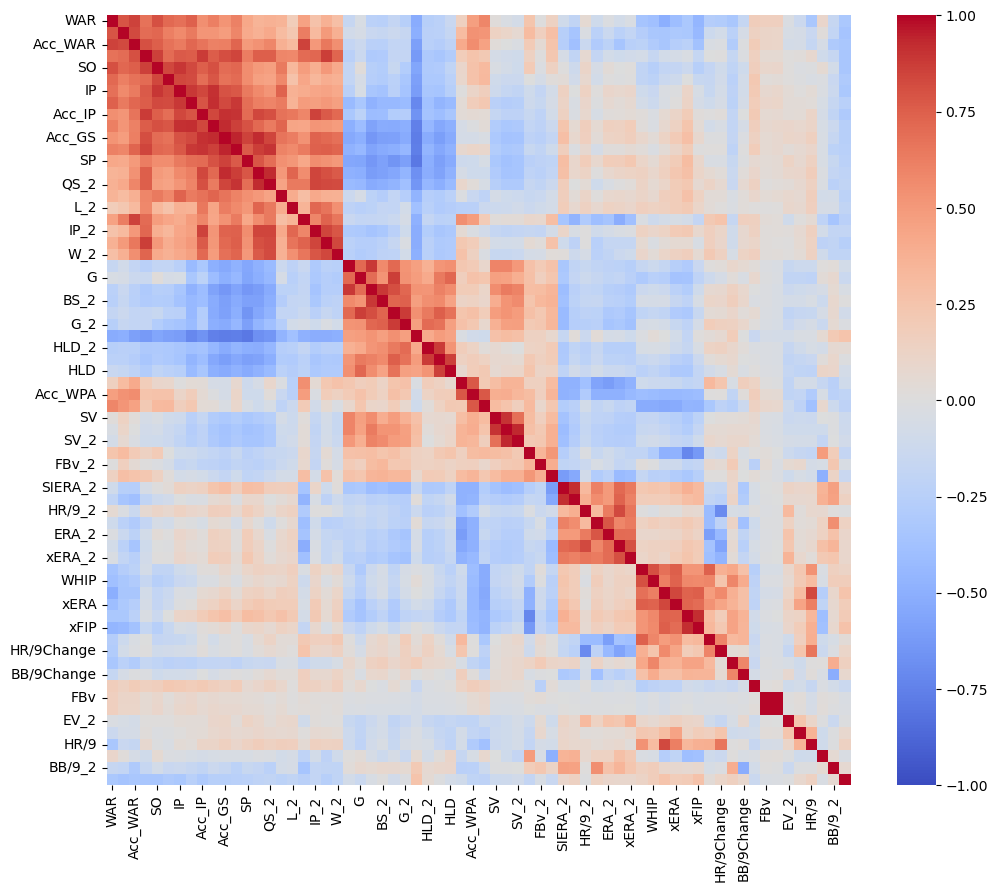

In [12]:
from scipy.cluster.hierarchy import linkage, dendrogram

linked = linkage(correlation_matrix, method='ward')

dendro = dendrogram(linked, no_plot=True)
reordered_corr_matrix = correlation_matrix.iloc[dendro['leaves'], dendro['leaves']]

plt.figure(figsize=(12, 10))

sns.heatmap(reordered_corr_matrix, annot=False, cmap="coolwarm", vmin=-1, vmax=1)

plt.savefig('corr_matrix_clustered.png')

plt.show()


In [13]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df2[['Acc_WAR', 'WAR', 'WAR_2']]

X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


   feature       VIF
0    const  1.791902
1  Acc_WAR       inf
2      WAR       inf
3    WAR_2       inf


C:\Users\mfran\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


The output shows infinite VIF values for Acc_WAR, WAR, and WAR_2, indicating perfect multicollinearity among these variables. This is expected because Acc_WAR is a direct linear combination of WAR and WAR_2.

Given this result, it is clear that we should not include all three variables in the model simultaneously. Including highly collinear variables can lead to issues in the model.

I will retain Only Acc_WAR: Since Acc_WAR has the highest correlation with the target variable and encapsulates the information from both WAR and WAR_2, the best approach would be to use only Acc_WAR and exclude WAR and WAR_2.


The same process will be done for the 'Acc' variables and also the ones ending in '_2'. Only the one with the highest colinearity will be kept. 



Im going to run one model with all of the variables and then use it as reference for improvement. 

In [14]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 67 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          508 non-null    object 
 1   AAV           508 non-null    float64
 2   minor_league  508 non-null    bool   
 3   SP            508 non-null    bool   
 4   RP            508 non-null    bool   
 5   Yrs           508 non-null    int64  
 6   W             508 non-null    int64  
 7   L             508 non-null    int64  
 8   ERA           508 non-null    float64
 9   WHIP          508 non-null    float64
 10  G             508 non-null    int64  
 11  GS            508 non-null    int64  
 12  QS            508 non-null    int64  
 13  SV            508 non-null    int64  
 14  BS            508 non-null    int64  
 15  HLD           508 non-null    int64  
 16  IP            508 non-null    float64
 17  SO            508 non-null    int64  
 18  K/9           508 non-null    

## Train-test split

For the train test we will be using different combinations: 80-20 and 70-30. This is the 80-20 version as the file name states. The results will be kept in different tables for comparison. To obtain this we modify 'test_size=0.2' 0.2 or 0.3 depending on the combination.

In [15]:
target = "AAV"
features = [col for col in df2.columns if col != target and col!= "Name"]
X, y = df2[features], df2[target]

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (406, 65)
X_test shape: (102, 65)
y_train shape: (406,)
y_test shape: (102,)


C:\Users\mfran\AppData\Local\Temp\ipykernel_12508\3840007699.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_train, shade=True)


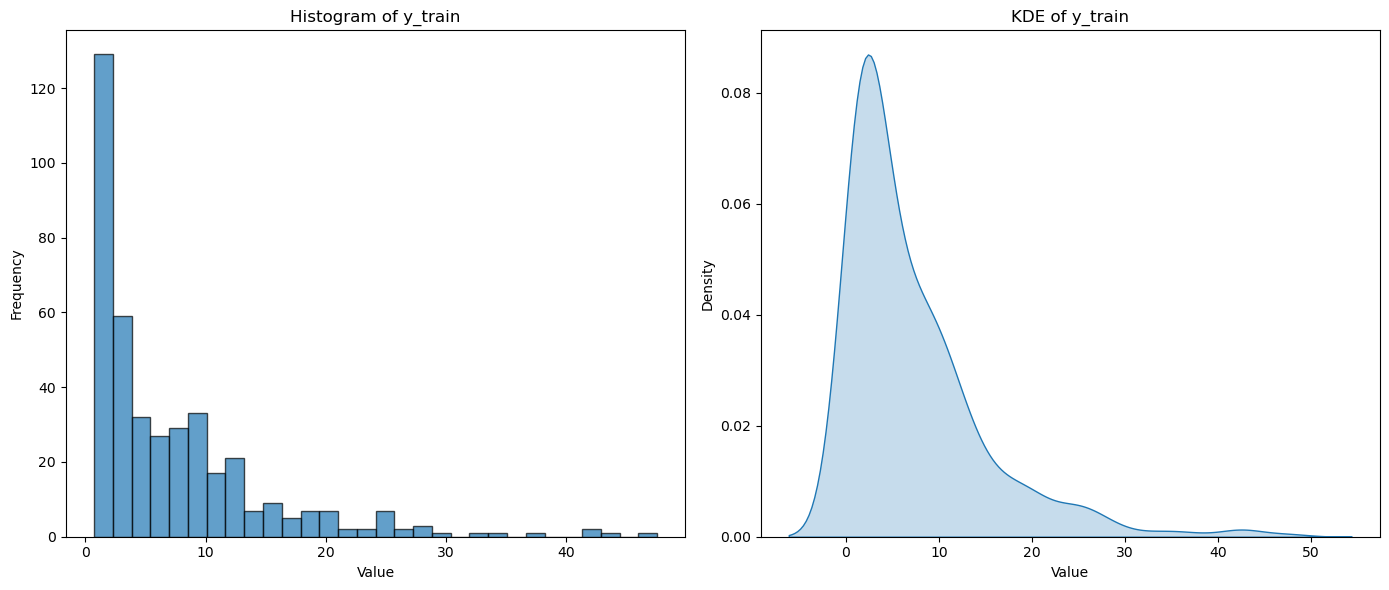

In [17]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(y_train, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of y_train')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.kdeplot(y_train, shade=True)
plt.title('KDE of y_train')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

C:\Users\mfran\AppData\Local\Temp\ipykernel_12508\893388450.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, shade=True)


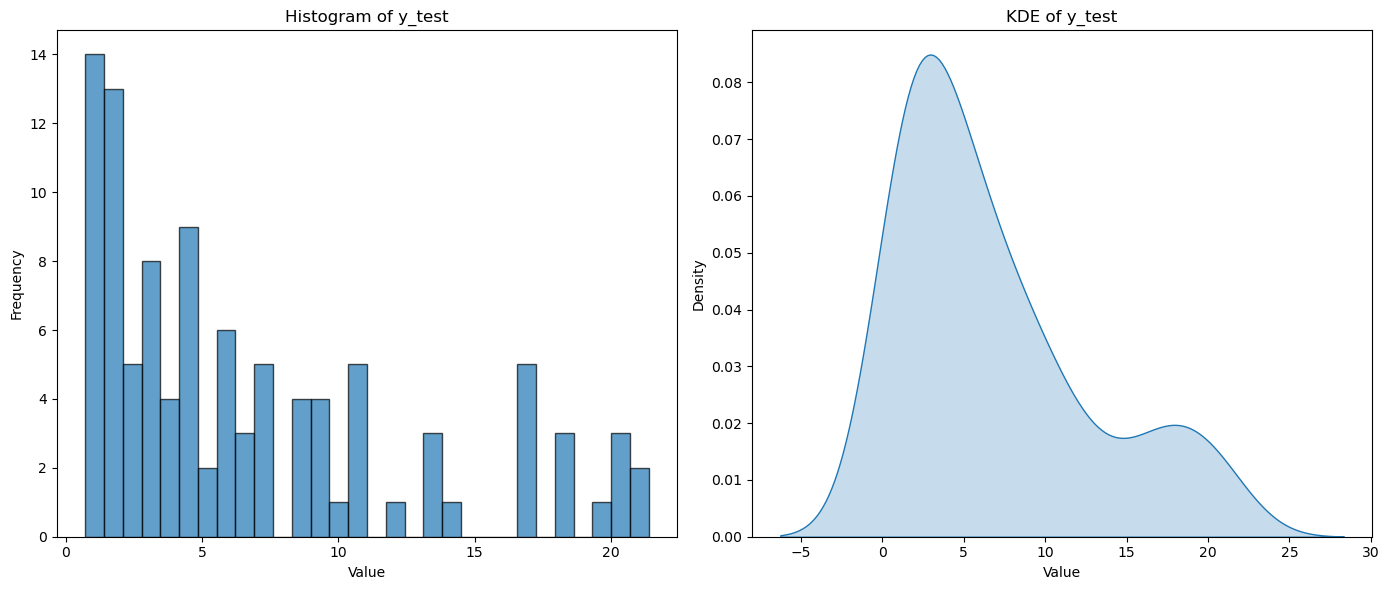

In [18]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(y_test, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of y_test')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.kdeplot(y_test, shade=True)
plt.title('KDE of y_test')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

## Linear Model (with all variables)

In [19]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [20]:
linear_model.coef_, linear_model.intercept_

(array([-1.20266982e+00,  7.34866225e-01, -1.04186887e+00,  9.62769467e-02,
        -6.39678812e-02,  5.87767454e-02,  2.06811092e+08,  6.66530647e-02,
         7.54359038e+02, -9.76938418e+01,  3.73230653e+01,  8.13912200e+02,
        -2.08564920e+02,  1.37917648e+02, -1.06221627e+03, -8.07644580e+02,
         2.84404074e+01,  1.79457386e+01, -2.79937379e+01, -3.11657104e+02,
        -6.44113490e-02, -7.27110077e-04, -2.06811093e+08, -1.24366532e+00,
         7.54425647e+02, -9.75042530e+01,  3.73197438e+01,  8.13827894e+02,
        -2.08654920e+02,  1.37880005e+02, -1.06223787e+03, -8.07694875e+02,
        -2.90624987e+01, -1.65047187e+01,  2.98403145e+01,  3.11936273e+02,
         1.06222718e+03,  8.07697952e+02, -7.54447162e+02,  9.74844818e+01,
        -3.71816472e+01, -8.13817722e+02,  2.08678131e+02, -1.37862901e+02,
        -2.06811092e+08,  3.11658983e+02, -2.85170942e+01, -1.74905386e+01,
         2.75299129e+01,  1.18109226e+00,  8.67123349e+01, -3.72223498e-01,
         1.2

In [21]:
linear_y_pred = linear_model.predict(X_test)

results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = linear_y_pred
results_df["err"] = results_df["y_real"] - results_df["y_pred"]
results_df["%_err"] = results_df["err"] / results_df["y_real"] * 100
results_df

,minor_league,SP,RP,Yrs,W,L,ERA,WHIP,G,GS,...,WPA_2,SIERA_2,xERA_2,EV_2,Acc_WAR,Acc_WPA,y_real,y_pred,err,%_err
444,True,False,True,12,1,1,5.094341,1.556604,37,0,...,-0.406518,5.300887,6.09,85.801338,0.019265,-1.224556,1.479137,-3.508672,4.987808,337.210734
344,False,True,False,6,2,2,4.940000,1.260000,7,7,...,-0.581658,4.603308,5.03,89.231379,0.872343,-0.479032,4.160566,5.109468,-0.948902,-22.807031
47,False,False,True,9,7,2,3.281768,1.193370,61,0,...,-0.061196,5.461969,4.78,90.073819,-0.332473,-0.449046,4.500000,6.248549,-1.748549,-38.856649
67,False,False,True,7,2,2,3.375000,1.243421,51,0,...,-0.470414,3.680546,5.38,87.570701,-0.194070,-0.170446,6.000000,6.693072,-0.693072,-11.551201
363,False,True,True,10,7,9,3.570000,1.290000,36,30,...,-2.176972,5.571353,6.70,88.543539,1.432180,-2.293026,8.321133,8.641259,-0.320126,-3.847139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,False,True,True,11,12,8,2.890000,1.260000,32,32,...,-0.492374,4.521661,5.51,88.601277,4.649118,1.430136,19.536665,15.976058,3.560607,18.225257
224,False,False,True,14,3,2,2.138614,1.009901,30,4,...,-0.174882,4.286845,5.16,88.147461,1.898215,0.334268,1.371416,3.289692,-1.918277,-139.875667
110,False,True,False,9,7,8,3.470220,1.194357,22,22,...,-0.282542,4.405090,5.05,88.845007,1.612395,0.653820,9.445207,6.817325,2.627882,27.822387
428,False,False,True,7,3,6,3.610466,1.151163,61,0,...,1.634982,3.527367,3.17,87.968971,2.181372,3.269964,16.566334,12.069185,4.497148,27.146310


### Evaluation Metrics

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

print(f"RMSE: {mean_squared_error(y_test, linear_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, linear_y_pred)}")
print(f"R^2: {r2_score(y_test, linear_y_pred)}")

RMSE: 3.59318319106573
MAPE: 0.6487790486962602
R^2: 0.6195373883577687


#### Correction for negative predictions

In [23]:
negative_values_exist = (results_df["y_pred"] < 0).any()

if negative_values_exist:
    print("There are negative values in the 'y_pred' column.")
else:
    print("There are no negative values in the 'y_pred' column.")

There are negative values in the 'y_pred' column.


In [24]:
linear_model = LinearRegression()

y_train_log = np.log(y_train)
linear_model.fit(X_train, y_train_log)

linear_y_pred_log = linear_model.predict(X_test)


linear_y_pred = np.exp(linear_y_pred_log)

results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = linear_y_pred
results_df["err"] = results_df["y_real"] - results_df["y_pred"]
results_df["%_err"] = results_df["err"] / results_df["y_real"] * 100
results_df

,minor_league,SP,RP,Yrs,W,L,ERA,WHIP,G,GS,...,WPA_2,SIERA_2,xERA_2,EV_2,Acc_WAR,Acc_WPA,y_real,y_pred,err,%_err
444,True,False,True,12,1,1,5.094341,1.556604,37,0,...,-0.406518,5.300887,6.09,85.801338,0.019265,-1.224556,1.479137,0.501130,0.978007,66.120138
344,False,True,False,6,2,2,4.940000,1.260000,7,7,...,-0.581658,4.603308,5.03,89.231379,0.872343,-0.479032,4.160566,3.341039,0.819527,19.697489
47,False,False,True,9,7,2,3.281768,1.193370,61,0,...,-0.061196,5.461969,4.78,90.073819,-0.332473,-0.449046,4.500000,3.096587,1.403413,31.186957
67,False,False,True,7,2,2,3.375000,1.243421,51,0,...,-0.470414,3.680546,5.38,87.570701,-0.194070,-0.170446,6.000000,3.711804,2.288196,38.136593
363,False,True,True,10,7,9,3.570000,1.290000,36,30,...,-2.176972,5.571353,6.70,88.543539,1.432180,-2.293026,8.321133,6.366866,1.954267,23.485592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,False,True,True,11,12,8,2.890000,1.260000,32,32,...,-0.492374,4.521661,5.51,88.601277,4.649118,1.430136,19.536665,11.803672,7.732994,39.581953
224,False,False,True,14,3,2,2.138614,1.009901,30,4,...,-0.174882,4.286845,5.16,88.147461,1.898215,0.334268,1.371416,2.957362,-1.585946,-115.643008
110,False,True,False,9,7,8,3.470220,1.194357,22,22,...,-0.282542,4.405090,5.05,88.845007,1.612395,0.653820,9.445207,7.550009,1.895198,20.065180
428,False,False,True,7,3,6,3.610466,1.151163,61,0,...,1.634982,3.527367,3.17,87.968971,2.181372,3.269964,16.566334,10.211958,6.354375,38.357161


In [25]:
print(f"RMSE: {mean_squared_error(y_test, linear_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, linear_y_pred)}")
print(f"R^2: {r2_score(y_test, linear_y_pred)}")

RMSE: 4.2042821548766405
MAPE: 0.4179376243919961
R^2: 0.47912084860829296


### Evaluating per ranges

#### Testing 0-5 range values

In [26]:
range_min, range_max = 0, 5

def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_df['y_real_in_range'] = results_df['y_real'].apply(lambda y: range_min <= y <= range_max)

results_df['in_range'] = results_df.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)

total_y_real_in_range = results_df['y_real_in_range'].sum()

correct_predictions = results_df['in_range'].sum()

print(f'Number of y_real values in the range {range_min}-{range_max}: {total_y_real_in_range}')
print(f'Number of correct predictions in the range {range_min}-{range_max}: {correct_predictions}')

Number of y_real values in the range 0-5: 54
Number of correct predictions in the range 0-5: 48


#### All ranges visualized with a bar plot

   Range  Total_y_real_in_range  Correct_Predictions
0    0-5                     54                   48
1   5-10                     24                   11
2  10-15                     11                    1
3  15-20                     10                    1
4  20-25                      5                    1
5  25-30                      0                    0
6  30-35                      0                    0
7  35-40                      0                    0
8    40+                      0                    0


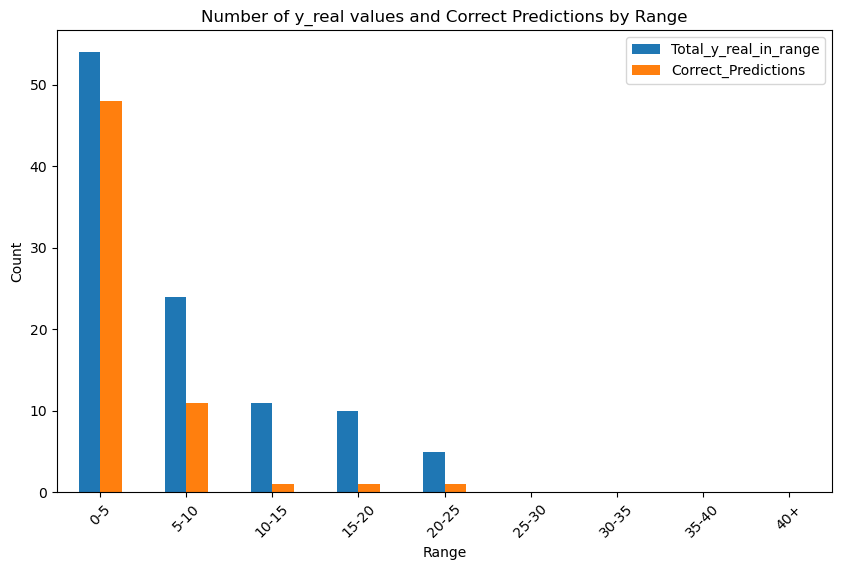

In [27]:
ranges = [ (0, 5), (5, 10), (10, 15), (15, 20), (20, 25), (25, 30), (30, 35), (35, 40), (40, float('inf'))]

def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_list = []

for range_min, range_max in ranges:
    results_df['y_real_in_range'] = results_df['y_real'].apply(lambda y: range_min <= y <= range_max)
    results_df['in_range'] = results_df.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)
    total_y_real_in_range = results_df['y_real_in_range'].sum()
    
    correct_predictions = results_df['in_range'].sum()

    results_list.append({
        'Range': f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+',
        'Total_y_real_in_range': total_y_real_in_range,
        'Correct_Predictions': correct_predictions
    })

results_summary = pd.DataFrame(results_list)

print(results_summary)

results_summary.set_index('Range').plot(kind='bar', figsize=(10, 6))
plt.title('Number of y_real values and Correct Predictions by Range')
plt.xlabel('Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Confusion Matrix


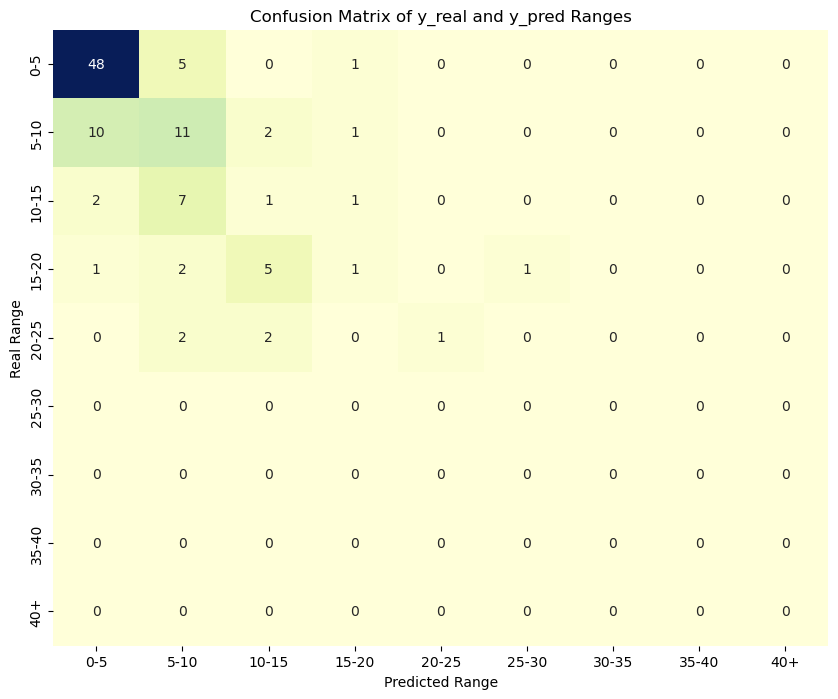

In [28]:
confusion_matrix = np.zeros((len(ranges), len(ranges)), dtype=int)

for i, (real_range_min, real_range_max) in enumerate(ranges):
    for j, (pred_range_min, pred_range_max) in enumerate(ranges):
        count = ((results_df['y_real'] >= real_range_min) & (results_df['y_real'] <= real_range_max) &
                 (results_df['y_pred'] >= pred_range_min) & (results_df['y_pred'] <= pred_range_max)).sum()
        confusion_matrix[i, j] = count

range_labels = [f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+' for range_min, range_max in ranges]

confusion_df = pd.DataFrame(confusion_matrix, index=range_labels, columns=range_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title('Confusion Matrix of y_real and y_pred Ranges')
plt.xlabel('Predicted Range')
plt.ylabel('Real Range')
plt.show()

In [29]:
percent_correct = np.zeros(len(ranges))

for i in range(len(ranges)):
    total_y_real_in_range = confusion_matrix[i, :].sum()
    correct_predictions = confusion_matrix[i, i]
    if total_y_real_in_range > 0:
        percent_correct[i] = (correct_predictions / total_y_real_in_range) * 100

range_labels = [f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+' for range_min, range_max in ranges]

print("Percentage of Correct Predictions per Bin:")
for label, percentage in zip(range_labels, percent_correct):
    print(f'{label}: {percentage:.2f}%')

Percentage of Correct Predictions per Bin:
0-5: 88.89%
5-10: 45.83%
10-15: 9.09%
15-20: 10.00%
20-25: 20.00%
25-30: 0.00%
30-35: 0.00%
35-40: 0.00%
40+: 0.00%


## Stratified Sampling 

Given the imbalance in the target variable (AAV), it is essential to ensure that both the training and test sets have a representative distribution of the target variable. This approach can help the model generalize better.

We can achieve a balanced split using stratified sampling. Stratified sampling will ensure that both the training and test sets have a similar distribution of the target variable.

If AAV is highly imbalanced with continuous values, stratified sampling based on the exact values might not always be feasible or meaningful. In such cases, we might need to create bins or categories for AAV before stratified sampling. For example:

Bin 1: AAV values below or equal to the 25th percentile
Bin 2: AAV values between the 25th and 50th percentiles
Bin 3: AAV values between the 50th and 75th percentiles
Bin 4: AAV values above the 75th percentile

In [30]:
y.describe()

count    508.000000
mean       7.165309
std        7.294814
min        0.715847
25%        1.783100
50%        4.512836
75%        9.942323
max       47.542409
Name: AAV, dtype: float64

In [31]:
q25 = df2['AAV'].quantile(0.25)
q50 = df2['AAV'].quantile(0.50)
q75 = df2['AAV'].quantile(0.75)

bins = [df2['AAV'].min(), q25, q50, q75, df2['AAV'].max()]
labels = [1, 2, 3, 4]
df2['AAV_binned'] = pd.cut(df2['AAV'], bins=bins, labels=labels, include_lowest=True)

y_binned = df2['AAV_binned']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y_binned)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

print(f'Train set AAV distribution:\n{y_train.describe()}')
print(f'Test set AAV distribution:\n{y_test.describe()}')


X_train shape: (406, 65)
X_test shape: (102, 65)
y_train shape: (406,)
y_test shape: (102,)
Train set AAV distribution:
count    406.000000
mean       7.297195
std        7.585079
min        0.715847
25%        1.783100
50%        4.512836
75%        9.942323
max       47.542409
Name: AAV, dtype: float64
Test set AAV distribution:
count    102.000000
mean       6.640350
std        6.006141
min        0.715847
25%        1.816079
50%        4.616619
75%        9.790885
max       26.844273
Name: AAV, dtype: float64


C:\Users\mfran\AppData\Local\Temp\ipykernel_12508\3840007699.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_train, shade=True)


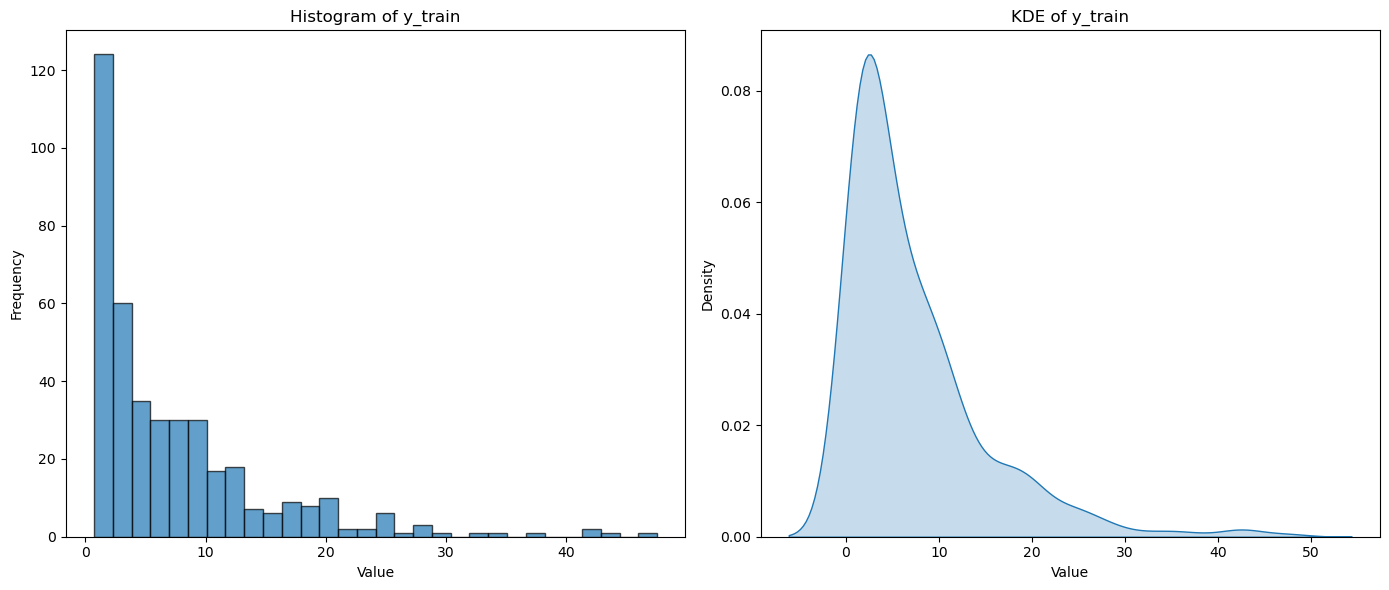

In [32]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(y_train, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of y_train')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.kdeplot(y_train, shade=True)
plt.title('KDE of y_train')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

C:\Users\mfran\AppData\Local\Temp\ipykernel_12508\893388450.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, shade=True)


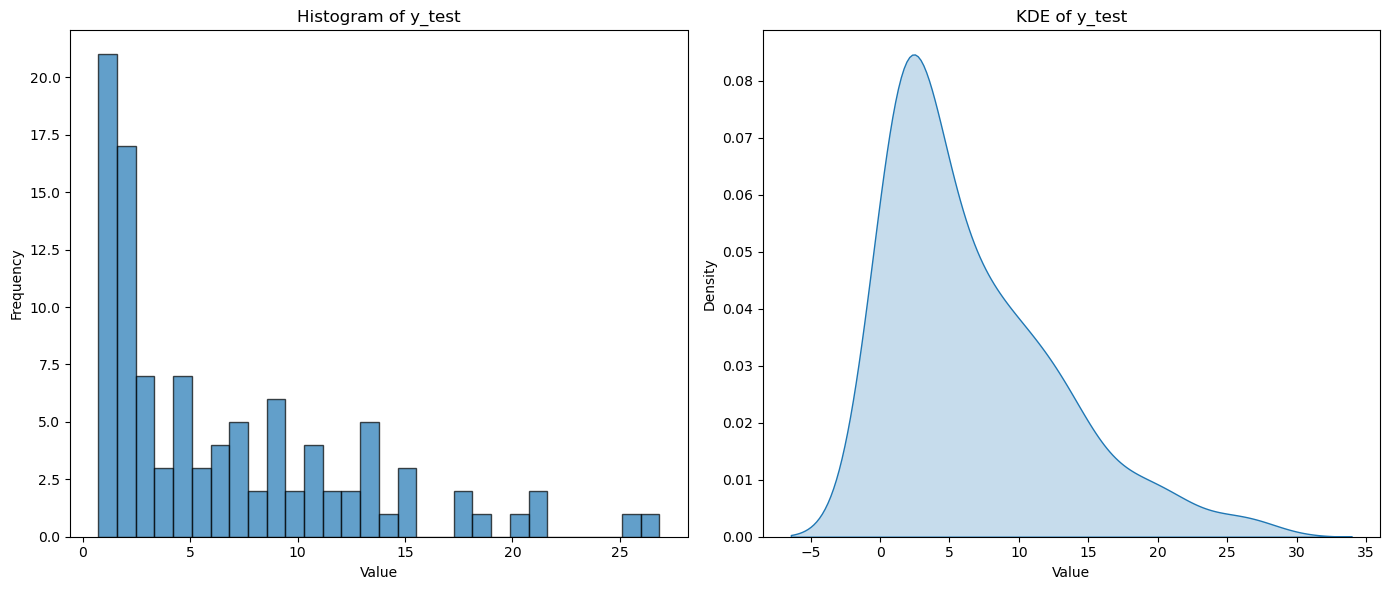

In [33]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(y_test, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of y_test')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.kdeplot(y_test, shade=True)
plt.title('KDE of y_test')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

### Linear Model (all variables, stratified sampling)

In [34]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [35]:
linear_model = LinearRegression()

y_train_log = np.log(y_train)
linear_model.fit(X_train, y_train_log)

linear_y_pred_log = linear_model.predict(X_test)


linear_y_pred = np.exp(linear_y_pred_log)

results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = linear_y_pred
results_df["err"] = results_df["y_real"] - results_df["y_pred"]
results_df["%_err"] = results_df["err"] / results_df["y_real"] * 100
results_df

,minor_league,SP,RP,Yrs,W,L,ERA,WHIP,G,GS,...,WPA_2,SIERA_2,xERA_2,EV_2,Acc_WAR,Acc_WPA,y_real,y_pred,err,%_err
234,False,False,True,14,4,4,4.991598,1.386555,50,0,...,0.467670,3.671117,2.77,91.175364,0.794563,0.063238,2.742831,2.139540,0.603291,21.995191
98,False,True,False,15,8,10,3.350000,1.230000,25,24,...,-0.717636,4.432639,4.92,88.428472,3.971480,-1.051730,8.450975,12.549586,-4.098611,-48.498680
465,False,True,False,6,9,8,4.764706,1.307487,24,21,...,0.659078,3.993242,4.02,88.475727,3.911526,-0.211822,2.342204,9.790203,-7.447999,-317.991014
374,False,True,False,6,7,9,4.935484,1.303226,32,28,...,-2.144940,5.444745,6.12,87.432726,0.749912,-2.896780,13.076066,6.173654,6.902412,52.786609
347,False,False,True,11,5,2,2.548951,1.059441,62,0,...,-2.192904,4.439800,5.55,88.886497,1.485153,-0.800880,4.754933,5.765492,-1.010559,-21.252852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,False,True,False,20,7,14,6.482517,1.587413,28,28,...,1.111096,4.369841,4.28,90.001284,2.805918,-1.745914,2.070792,7.127041,-5.056249,-244.169843
78,False,False,True,8,6,4,4.464568,1.110236,38,0,...,0.073078,3.554938,5.11,91.737224,0.518303,-0.785634,1.100000,2.649414,-1.549414,-140.855811
395,False,True,True,11,5,10,5.720000,1.520000,28,22,...,-1.460748,5.340246,4.68,88.990998,0.652967,-3.517974,2.366619,3.220698,-0.854079,-36.088570
232,False,True,False,9,10,4,3.829327,1.182692,26,26,...,-0.572746,4.667681,6.57,89.047275,2.385181,-0.036096,13.714156,8.345774,5.368383,39.144826


### Evaluation Metrics (all variables stratified sampling)

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

print(f"RMSE: {mean_squared_error(y_test, linear_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, linear_y_pred)}")
print(f"R^2: {r2_score(y_test, linear_y_pred)}")

RMSE: 4.721236034147105
MAPE: 0.513601004985501
R^2: 0.37597904244478486


Non stratified train splits: 
RMSE: 3.59318319106573
MAPE: 0.6487790486962602
R^2: 0.6195373883577687

Stratified train splits:
RMSE: 4.721236034147105
MAPE: 0.513601004985501
R^2: 0.37597904244478486

In [37]:
df2.drop(columns=['AAV_binned'], inplace=True)

## Ridge Regression (no stratified)

In [38]:
target = "AAV"
features = [col for col in df2.columns if col != target and col!= "Name"]
X, y = df2[features], df2[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (406, 65)
X_test shape: (102, 65)
y_train shape: (406,)
y_test shape: (102,)


In [39]:
from sklearn.linear_model import Ridge

ridge_model = Ridge()

ridge_model.fit(X_train, y_train)

ridge_y_pred = ridge_model.predict(X_test)

results_df_ridge = X_test.copy()
results_df_ridge["y_real"] = y_test
results_df_ridge["y_pred"] = ridge_y_pred
results_df_ridge["err"] = results_df_ridge["y_real"] - results_df_ridge["y_pred"]
results_df_ridge["%_err"] = results_df_ridge["err"] / results_df_ridge["y_real"] * 100

results_df_ridge

,minor_league,SP,RP,Yrs,W,L,ERA,WHIP,G,GS,...,WPA_2,SIERA_2,xERA_2,EV_2,Acc_WAR,Acc_WPA,y_real,y_pred,err,%_err
444,True,False,True,12,1,1,5.094341,1.556604,37,0,...,-0.406518,5.300887,6.09,85.801338,0.019265,-1.224556,1.479137,-3.519720,4.998857,337.957699
344,False,True,False,6,2,2,4.940000,1.260000,7,7,...,-0.581658,4.603308,5.03,89.231379,0.872343,-0.479032,4.160566,5.051538,-0.890972,-21.414671
47,False,False,True,9,7,2,3.281768,1.193370,61,0,...,-0.061196,5.461969,4.78,90.073819,-0.332473,-0.449046,4.500000,6.177986,-1.677986,-37.288569
67,False,False,True,7,2,2,3.375000,1.243421,51,0,...,-0.470414,3.680546,5.38,87.570701,-0.194070,-0.170446,6.000000,6.655667,-0.655667,-10.927777
363,False,True,True,10,7,9,3.570000,1.290000,36,30,...,-2.176972,5.571353,6.70,88.543539,1.432180,-2.293026,8.321133,8.595778,-0.274645,-3.300568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,False,True,True,11,12,8,2.890000,1.260000,32,32,...,-0.492374,4.521661,5.51,88.601277,4.649118,1.430136,19.536665,16.093258,3.443407,17.625360
224,False,False,True,14,3,2,2.138614,1.009901,30,4,...,-0.174882,4.286845,5.16,88.147461,1.898215,0.334268,1.371416,3.320572,-1.949156,-142.127329
110,False,True,False,9,7,8,3.470220,1.194357,22,22,...,-0.282542,4.405090,5.05,88.845007,1.612395,0.653820,9.445207,6.794094,2.651113,28.068346
428,False,False,True,7,3,6,3.610466,1.151163,61,0,...,1.634982,3.527367,3.17,87.968971,2.181372,3.269964,16.566334,12.000407,4.565927,27.561479


### Evaluation Metrics (Ridge Regression)

In [40]:
print(f"RMSE: {mean_squared_error(y_test, ridge_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, ridge_y_pred)}")
print(f"R^2: {r2_score(y_test, ridge_y_pred)}")

RMSE: 3.5779814507915098
MAPE: 0.6508894993763001
R^2: 0.6227498375507219


#### Correction for negative predictions

In [41]:
negative_values_exist = (results_df_ridge["y_pred"] < 0).any()

if negative_values_exist:
    print("There are negative values in the 'y_pred' column.")
else:
    print("There are no negative values in the 'y_pred' column.")

There are negative values in the 'y_pred' column.


In [42]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


y_train_log = np.log(y_train)


ridge_model = Ridge()
ridge_model.fit(X_train, y_train_log)


ridge_y_pred_log = ridge_model.predict(X_test)


ridge_y_pred = np.exp(ridge_y_pred_log)

rmse = np.sqrt(mean_squared_error(y_test, ridge_y_pred))
r2 = r2_score(y_test, ridge_y_pred)
mape = np.mean(np.abs((y_test - ridge_y_pred) / y_test)) 

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"R^2: {r2}")


results_df_ridge = X_test.copy()
results_df_ridge["y_real"] = y_test
results_df_ridge["y_pred"] = ridge_y_pred
results_df_ridge["err"] = results_df_ridge["y_real"] - results_df_ridge["y_pred"]
results_df_ridge["%_err"] = results_df_ridge["err"] / results_df_ridge["y_real"] * 100

results_df_ridge

RMSE: 4.206742962186541
MAPE: 0.4246764240421341
R^2: 0.47851091887656094


,minor_league,SP,RP,Yrs,W,L,ERA,WHIP,G,GS,...,WPA_2,SIERA_2,xERA_2,EV_2,Acc_WAR,Acc_WPA,y_real,y_pred,err,%_err
444,True,False,True,12,1,1,5.094341,1.556604,37,0,...,-0.406518,5.300887,6.09,85.801338,0.019265,-1.224556,1.479137,0.504629,0.974508,65.883537
344,False,True,False,6,2,2,4.940000,1.260000,7,7,...,-0.581658,4.603308,5.03,89.231379,0.872343,-0.479032,4.160566,3.382948,0.777619,18.690214
47,False,False,True,9,7,2,3.281768,1.193370,61,0,...,-0.061196,5.461969,4.78,90.073819,-0.332473,-0.449046,4.500000,3.014553,1.485447,33.009933
67,False,False,True,7,2,2,3.375000,1.243421,51,0,...,-0.470414,3.680546,5.38,87.570701,-0.194070,-0.170446,6.000000,3.754051,2.245949,37.432479
363,False,True,True,10,7,9,3.570000,1.290000,36,30,...,-2.176972,5.571353,6.70,88.543539,1.432180,-2.293026,8.321133,6.340082,1.981051,23.807468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,False,True,True,11,12,8,2.890000,1.260000,32,32,...,-0.492374,4.521661,5.51,88.601277,4.649118,1.430136,19.536665,11.887046,7.649619,39.155195
224,False,False,True,14,3,2,2.138614,1.009901,30,4,...,-0.174882,4.286845,5.16,88.147461,1.898215,0.334268,1.371416,2.913974,-1.542558,-112.479248
110,False,True,False,9,7,8,3.470220,1.194357,22,22,...,-0.282542,4.405090,5.05,88.845007,1.612395,0.653820,9.445207,7.615623,1.829584,19.370506
428,False,False,True,7,3,6,3.610466,1.151163,61,0,...,1.634982,3.527367,3.17,87.968971,2.181372,3.269964,16.566334,10.165964,6.400370,38.634800


#### Testing 0-4 range values

In [43]:
range_min, range_max = 0, 5

def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_df_ridge['y_real_in_range'] = results_df_ridge['y_real'].apply(lambda y: range_min <= y <= range_max)

results_df_ridge['in_range'] = results_df_ridge.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)

total_y_real_in_range = results_df_ridge['y_real_in_range'].sum()

correct_predictions = results_df_ridge['in_range'].sum()

print(f'Number of y_real values in the range {range_min}-{range_max}: {total_y_real_in_range}')
print(f'Number of correct predictions in the range {range_min}-{range_max}: {correct_predictions}')

Number of y_real values in the range 0-5: 54
Number of correct predictions in the range 0-5: 48


   Range  Total_y_real_in_range  Correct_Predictions
0    0-5                     54                   48
1   5-10                     24                   11
2  10-15                     11                    1
3  15-20                     10                    1
4  20-25                      5                    1
5  25-30                      0                    0
6  30-35                      0                    0
7  35-40                      0                    0
8    40+                      0                    0


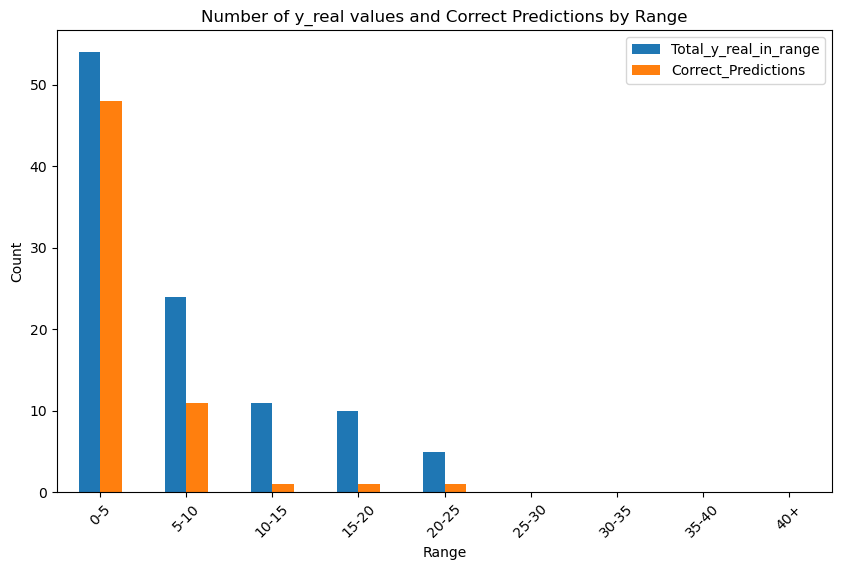

In [44]:
def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_list = []

for range_min, range_max in ranges:
    results_df_ridge['y_real_in_range'] = results_df_ridge['y_real'].apply(lambda y: range_min <= y <= range_max)
    results_df_ridge['in_range'] = results_df_ridge.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)
    total_y_real_in_range = results_df_ridge['y_real_in_range'].sum()
    
    correct_predictions = results_df_ridge['in_range'].sum()

    results_list.append({
        'Range': f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+',
        'Total_y_real_in_range': total_y_real_in_range,
        'Correct_Predictions': correct_predictions
    })

results_summary = pd.DataFrame(results_list)

print(results_summary)

results_summary.set_index('Range').plot(kind='bar', figsize=(10, 6))
plt.title('Number of y_real values and Correct Predictions by Range')
plt.xlabel('Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Confusion Matrix

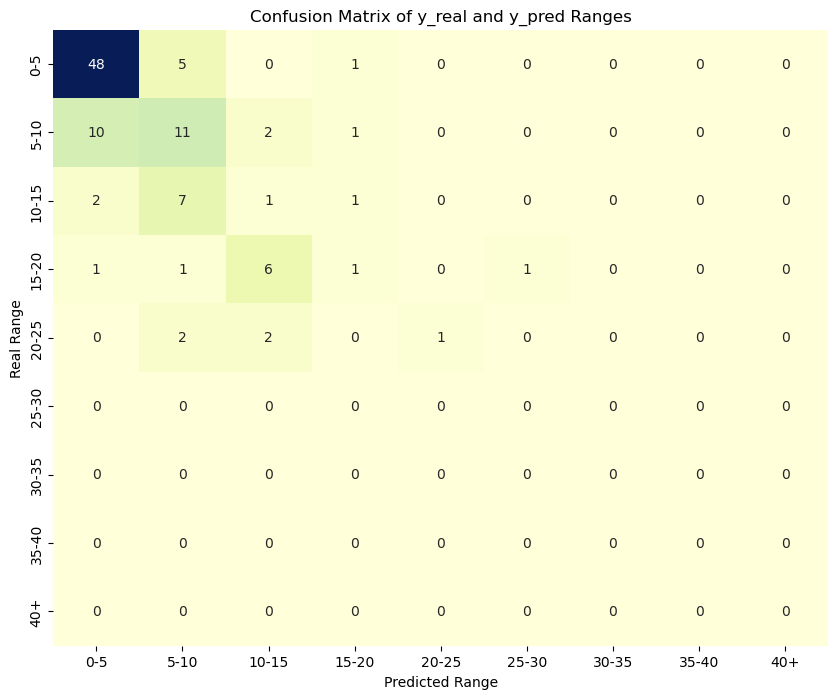

In [45]:
confusion_matrix = np.zeros((len(ranges), len(ranges)), dtype=int)

for i, (real_range_min, real_range_max) in enumerate(ranges):
    for j, (pred_range_min, pred_range_max) in enumerate(ranges):
        count = ((results_df_ridge['y_real'] >= real_range_min) & (results_df_ridge['y_real'] <= real_range_max) &
                 (results_df_ridge['y_pred'] >= pred_range_min) & (results_df_ridge['y_pred'] <= pred_range_max)).sum()
        confusion_matrix[i, j] = count

range_labels = [f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+' for range_min, range_max in ranges]

confusion_df = pd.DataFrame(confusion_matrix, index=range_labels, columns=range_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title('Confusion Matrix of y_real and y_pred Ranges')
plt.xlabel('Predicted Range')
plt.ylabel('Real Range')
plt.show()

In [46]:
percent_correct = np.zeros(len(ranges))

for i in range(len(ranges)):
    total_y_real_in_range = confusion_matrix[i, :].sum()
    correct_predictions = confusion_matrix[i, i]
    if total_y_real_in_range > 0:
        percent_correct[i] = (correct_predictions / total_y_real_in_range) * 100

range_labels = [f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+' for range_min, range_max in ranges]

print("Percentage of Correct Predictions per Bin:")
for label, percentage in zip(range_labels, percent_correct):
    print(f'{label}: {percentage:.2f}%')

Percentage of Correct Predictions per Bin:
0-5: 88.89%
5-10: 45.83%
10-15: 9.09%
15-20: 10.00%
20-25: 20.00%
25-30: 0.00%
30-35: 0.00%
35-40: 0.00%
40+: 0.00%


## XGBoost Regression

In [47]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor()

xgb_model.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)

results_df_xgb = X_test.copy()
results_df_xgb["y_real"] = y_test
results_df_xgb["y_pred"] = xgb_y_pred
results_df_xgb["err"] = results_df_xgb["y_real"] - results_df_xgb["y_pred"]
results_df_xgb["%_err"] = results_df_xgb["err"] / results_df_xgb["y_real"] * 100


results_df_xgb

,minor_league,SP,RP,Yrs,W,L,ERA,WHIP,G,GS,...,WPA_2,SIERA_2,xERA_2,EV_2,Acc_WAR,Acc_WPA,y_real,y_pred,err,%_err
444,True,False,True,12,1,1,5.094341,1.556604,37,0,...,-0.406518,5.300887,6.09,85.801338,0.019265,-1.224556,1.479137,1.138712,0.340425,23.015126
344,False,True,False,6,2,2,4.940000,1.260000,7,7,...,-0.581658,4.603308,5.03,89.231379,0.872343,-0.479032,4.160566,2.329414,1.831152,44.012092
47,False,False,True,9,7,2,3.281768,1.193370,61,0,...,-0.061196,5.461969,4.78,90.073819,-0.332473,-0.449046,4.500000,3.278220,1.221780,27.150668
67,False,False,True,7,2,2,3.375000,1.243421,51,0,...,-0.470414,3.680546,5.38,87.570701,-0.194070,-0.170446,6.000000,2.510180,3.489820,58.163659
363,False,True,True,10,7,9,3.570000,1.290000,36,30,...,-2.176972,5.571353,6.70,88.543539,1.432180,-2.293026,8.321133,11.079706,-2.758573,-33.151414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,False,True,True,11,12,8,2.890000,1.260000,32,32,...,-0.492374,4.521661,5.51,88.601277,4.649118,1.430136,19.536665,14.827275,4.709390,24.105393
224,False,False,True,14,3,2,2.138614,1.009901,30,4,...,-0.174882,4.286845,5.16,88.147461,1.898215,0.334268,1.371416,4.182413,-2.810997,-204.970499
110,False,True,False,9,7,8,3.470220,1.194357,22,22,...,-0.282542,4.405090,5.05,88.845007,1.612395,0.653820,9.445207,4.372310,5.072897,53.708695
428,False,False,True,7,3,6,3.610466,1.151163,61,0,...,1.634982,3.527367,3.17,87.968971,2.181372,3.269964,16.566334,8.953823,7.612510,45.951691


### Evaluation Metrics (XGBoost Regression)

In [48]:
print(f"RMSE: {mean_squared_error(y_test, xgb_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, xgb_y_pred)}")
print(f"R^2: {r2_score(y_test, xgb_y_pred)}")

RMSE: 4.062682117763152
MAPE: 0.5222493926975722
R^2: 0.5136163684364228


In [49]:
negative_values_exist = (results_df_xgb["y_pred"] < 0).any()

if negative_values_exist:
    print("There are negative values in the 'y_pred' column.")
else:
    print("There are no negative values in the 'y_pred' column.")

There are no negative values in the 'y_pred' column.


#### Testing 0-5 range values

In [50]:
range_min, range_max = 0, 5

def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_df_xgb['y_real_in_range'] = results_df_xgb['y_real'].apply(lambda y: range_min <= y <= range_max)

results_df_xgb['in_range'] = results_df_xgb.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)

total_y_real_in_range = results_df_xgb['y_real_in_range'].sum()

correct_predictions = results_df_xgb['in_range'].sum()

print(f'Number of y_real values in the range {range_min}-{range_max}: {total_y_real_in_range}')
print(f'Number of correct predictions in the range {range_min}-{range_max}: {correct_predictions}')

Number of y_real values in the range 0-5: 54
Number of correct predictions in the range 0-5: 46


#### All ranges visualized with a bar plot

   Range  Total Real in range  Correct Predictions
0    0-5                   54                   46
1   5-10                   24                    8
2  10-15                   11                    3
3  15-20                   10                    1
4  20-25                    5                    0
5  25-30                    0                    0
6  30-35                    0                    0
7  35-40                    0                    0
8    40+                    0                    0


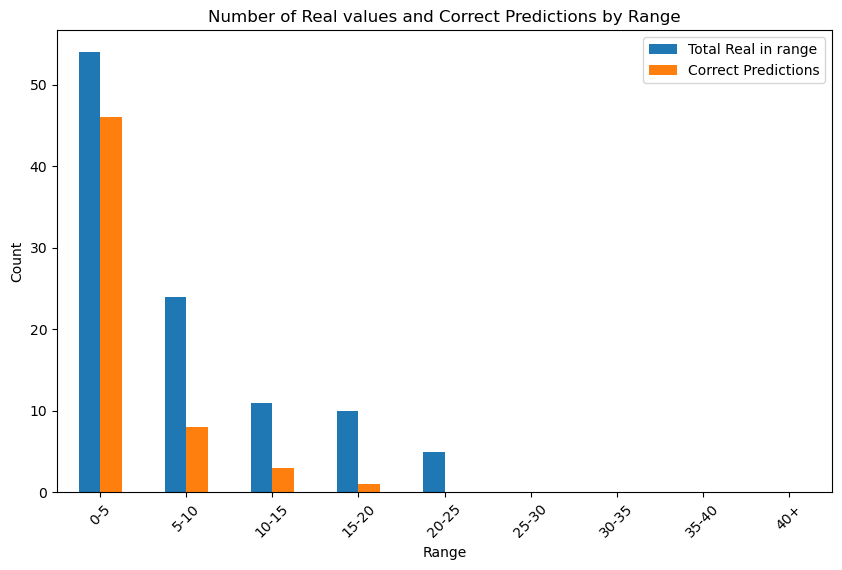

In [51]:
def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_list = []

for range_min, range_max in ranges:
    results_df_xgb['y_real_in_range'] = results_df_xgb['y_real'].apply(lambda y: range_min <= y <= range_max)
    results_df_xgb['in_range'] = results_df_xgb.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)
    total_y_real_in_range = results_df_xgb['y_real_in_range'].sum()
    
    correct_predictions = results_df_xgb['in_range'].sum()

    results_list.append({
        'Range': f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+',
        'Total Real in range': total_y_real_in_range,
        'Correct Predictions': correct_predictions
    })

results_summary = pd.DataFrame(results_list)

print(results_summary)

results_summary.set_index('Range').plot(kind='bar', figsize=(10, 6))
plt.title('Number of Real values and Correct Predictions by Range')
plt.xlabel('Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Confusion Matrix

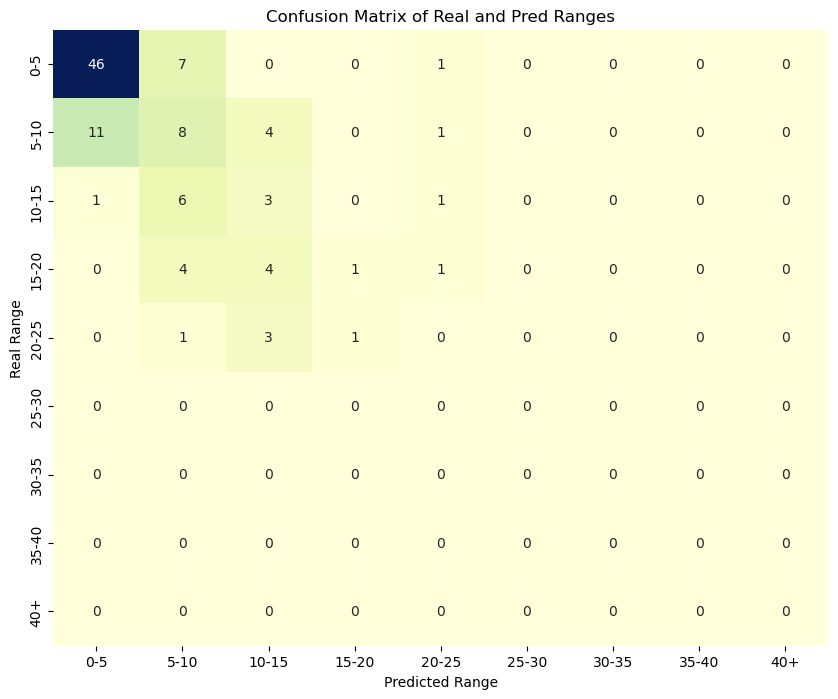

In [52]:
confusion_matrix = np.zeros((len(ranges), len(ranges)), dtype=int)

for i, (real_range_min, real_range_max) in enumerate(ranges):
    for j, (pred_range_min, pred_range_max) in enumerate(ranges):
        count = ((results_df_xgb['y_real'] >= real_range_min) & (results_df_xgb['y_real'] <= real_range_max) &
                 (results_df_xgb['y_pred'] >= pred_range_min) & (results_df_xgb['y_pred'] <= pred_range_max)).sum()
        confusion_matrix[i, j] = count

range_labels = [f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+' for range_min, range_max in ranges]

confusion_df = pd.DataFrame(confusion_matrix, index=range_labels, columns=range_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title('Confusion Matrix of Real and Pred Ranges')
plt.xlabel('Predicted Range')
plt.ylabel('Real Range')
plt.show()

In [53]:
percent_correct = np.zeros(len(ranges))

for i in range(len(ranges)):
    total_y_real_in_range = confusion_matrix[i, :].sum()
    correct_predictions = confusion_matrix[i, i]
    if total_y_real_in_range > 0:
        percent_correct[i] = (correct_predictions / total_y_real_in_range) * 100

range_labels = [f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+' for range_min, range_max in ranges]

print("Percentage of Correct Predictions per Bin:")
for label, percentage in zip(range_labels, percent_correct):
    print(f'{label}: {percentage:.2f}%')

Percentage of Correct Predictions per Bin:
0-5: 85.19%
5-10: 33.33%
10-15: 27.27%
15-20: 10.00%
20-25: 0.00%
25-30: 0.00%
30-35: 0.00%
35-40: 0.00%
40+: 0.00%


#### W_L_Ratio 

To this model I want to add a W_L ratio and see its correlation with AAV

In [54]:
df2['Acc_W'] = df2['W'] + df2['W_2']
df2['Acc_L'] = df2['L'] + df2['L_2']

df2['W_L_Ratio'] = df2.apply(lambda row: row['Acc_W'] / row['Acc_L'] if row['Acc_L'] != 0 else float('inf') if row['Acc_W'] != 0 else 0, axis=1)
df2[['Acc_W', 'Acc_L', 'W_L_Ratio']].head()

,Acc_W,Acc_L,W_L_Ratio
0,25,14,1.785714
1,16,13,1.230769
2,18,5,3.600000
3,23,22,1.045455
4,25,8,3.125000


In [55]:
##filtered_df = df2[(df2['W_2'] == 0) & (df2['L_2'] == 0)]
filtered_df = df2[(df2['W_L_Ratio'] > 20) ]

filtered_df[['W', 'W_2', 'L', 'L_2', 'Acc_W', 'Acc_L', 'W_L_Ratio']]

,W,W_2,L,L_2,Acc_W,Acc_L,W_L_Ratio
162,1,0,0,0,1,0,inf
192,6,0,0,0,6,0,inf
239,1,3,0,0,4,0,inf
315,4,0,0,0,4,0,inf
417,6,1,0,0,7,0,inf
494,1,2,0,0,3,0,inf


In [56]:
df2['Acc_L'] = df2['Acc_L'].apply(lambda x: x + 1 if x == 0 else x)

df2['W_L_Ratio'] = df2['Acc_W'] / df2['Acc_L']

print(df2[['W', 'W_2', 'L', 'L_2', 'Acc_W', 'Acc_L', 'W_L_Ratio']].head())

correlation = df2['W_L_Ratio'].corr(df2['AAV'])
print(f'Correlation between W_L_Ratio and AAV: {correlation}')

    W  W_2  L  L_2  Acc_W  Acc_L  W_L_Ratio
0  10   15  5    9     25     14   1.785714
1   8    8  8    5     16     13   1.230769
2   5   13  1    4     18      5   3.600000
3  12   11  9   13     23     22   1.045455
4  13   12  5    3     25      8   3.125000
Correlation between W_L_Ratio and AAV: 0.154203420732014


In [57]:
df2["W_L_Ratio"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 508 entries, 0 to 507
Series name: W_L_Ratio
Non-Null Count  Dtype  
--------------  -----  
508 non-null    float64
dtypes: float64(1)
memory usage: 4.1 KB


#### Checking multicolinearity between the new variables created

In [58]:
X = df2[['W_L_Ratio','L','W']]

X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

     feature       VIF
0      const  5.663881
1  W_L_Ratio  1.344429
2          L  1.976279
3          W  1.864976


There doesn't seem to be any correlation. For now, this means we will keep them. 

#### Checking multicolinearity between the different variables for time played

It is done taking into account the clustered correlation matrix done in the first steps.

In [59]:
X = df2[['GS', 'IP', 'QS','Acc_SO','SO','W']]

X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

  feature        VIF
0   const   8.447159
1      GS   9.451758
2      IP  11.129310
3      QS   8.017818
4  Acc_SO   4.266094
5      SO   9.591005
6       W   4.366932


In [60]:
X = df2[['IP', 'QS']]

X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

  feature       VIF
0   const  5.359859
1      IP  4.645125
2      QS  4.645125


In [61]:
X = df2[['W', 'L']]

X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

  feature       VIF
0   const  3.044036
1       W  1.513494
2       L  1.513494


### Selected Variables 

In [62]:
slc_columns=['AAV','QS', 'HLD_2','SO','Acc_WAR','Acc_WPA','BB/9','ERA','FIP','K/9','L','RP','SIERA','SP','W','WHIP','minor_league','xERA','xFIP']
columns_to_drop = [col for col in df2.columns if col not in slc_columns]
df2.drop(columns=columns_to_drop, inplace=True)

In [63]:
df2.head()

,AAV,minor_league,SP,RP,W,L,ERA,WHIP,QS,SO,K/9,BB/9,HLD_2,FIP,xFIP,SIERA,xERA,Acc_WAR,Acc_WPA
0,34.877193,False,True,False,10,5,3.136364,1.060606,12,167,11.386364,3.750000,0,3.997465,3.577480,3.663228,3.82,7.966784,5.364157
1,25.000000,False,True,False,8,8,1.790000,1.150000,17,183,8.950000,2.690000,0,2.825693,3.644259,3.949935,3.66,7.645342,3.818644
2,8.750000,False,True,False,5,1,2.283582,0.820896,7,74,9.940299,2.014925,0,3.598324,3.628791,3.445838,2.82,5.001775,3.346239
3,24.571429,False,True,False,12,9,4.460000,1.150000,15,202,9.390000,2.090000,0,4.029567,3.631652,3.751155,3.71,10.192750,2.951880
4,5.000000,False,True,False,13,5,2.460000,1.060000,11,137,9.360000,2.730000,0,4.029724,3.572727,3.817126,3.77,6.191165,4.462551


In [64]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AAV           508 non-null    float64
 1   minor_league  508 non-null    bool   
 2   SP            508 non-null    bool   
 3   RP            508 non-null    bool   
 4   W             508 non-null    int64  
 5   L             508 non-null    int64  
 6   ERA           508 non-null    float64
 7   WHIP          508 non-null    float64
 8   QS            508 non-null    int64  
 9   SO            508 non-null    int64  
 10  K/9           508 non-null    float64
 11  BB/9          508 non-null    float64
 12  HLD_2         508 non-null    int64  
 13  FIP           508 non-null    float64
 14  xFIP          508 non-null    float64
 15  SIERA         508 non-null    float64
 16  xERA          508 non-null    float64
 17  Acc_WAR       508 non-null    float64
 18  Acc_WPA       508 non-null    

In [65]:
numerical_columns = df2.select_dtypes(include=['number']).columns
boolean_columns = df2.select_dtypes(include=['bool']).columns

selected_columns = numerical_columns.union(boolean_columns)

correlation_matrix = df2[selected_columns].corr()

correlation_matrix.style.background_gradient("coolwarm", vmin=-1, vmax=1)

,AAV,Acc_WAR,Acc_WPA,BB/9,ERA,FIP,HLD_2,K/9,L,QS,RP,SIERA,SO,SP,W,WHIP,minor_league,xERA,xFIP
AAV,1.000000,0.833589,0.536313,-0.233117,-0.268117,-0.342961,-0.237728,0.305915,0.310883,0.642682,-0.503318,-0.324951,0.720249,0.408327,0.621211,-0.331762,-0.351841,-0.316110,-0.437135
Acc_WAR,0.833589,1.000000,0.557686,-0.287712,-0.224059,-0.339532,-0.249010,0.196788,0.377342,0.722666,-0.591198,-0.229892,0.753484,0.496440,0.675384,-0.295999,-0.328948,-0.263440,-0.370750
Acc_WPA,0.536313,0.557686,1.000000,-0.194430,-0.403228,-0.434322,0.131214,0.301695,-0.146439,0.172025,-0.086239,-0.423819,0.264351,-0.103578,0.264164,-0.416981,-0.199209,-0.435032,-0.413979
BB/9,-0.233117,-0.287712,-0.194430,1.000000,0.429505,0.378626,0.091071,0.128015,-0.038901,-0.221516,0.186020,0.447245,-0.196256,-0.149976,-0.226887,0.591082,0.150704,0.366144,0.448208
ERA,-0.268117,-0.224059,-0.403228,0.429505,1.000000,0.680756,-0.047255,-0.194607,0.114317,-0.077033,-0.017824,0.516799,-0.191722,0.103701,-0.190669,0.806564,0.122744,0.757315,0.517591
FIP,-0.342961,-0.339532,-0.434322,0.378626,0.680756,1.000000,-0.049346,-0.488371,0.165468,-0.038576,-0.000293,0.739267,-0.183553,0.135459,-0.133693,0.617248,0.253491,0.835988,0.752539
HLD_2,-0.237728,-0.249010,0.131214,0.091071,-0.047255,-0.049346,1.000000,0.125381,-0.263634,-0.380784,0.409135,-0.158455,-0.303653,-0.502791,-0.318637,-0.044719,0.052966,-0.109635,-0.039158
K/9,0.305915,0.196788,0.301695,0.128015,-0.194607,-0.488371,0.125381,1.000000,-0.154461,-0.110218,0.145348,-0.718863,0.197713,-0.238795,-0.001280,-0.282109,-0.179293,-0.480219,-0.632607
L,0.310883,0.377342,-0.146439,-0.038901,0.114317,0.165468,-0.263634,-0.154461,1.000000,0.640196,-0.473478,0.269215,0.645730,0.542508,0.582475,0.070728,-0.220143,0.180582,0.136262
QS,0.642682,0.722666,0.172025,-0.221516,-0.077033,-0.038576,-0.380784,-0.110218,0.640196,1.000000,-0.717288,0.122825,0.832344,0.692692,0.826733,-0.120166,-0.242916,0.010496,-0.064459


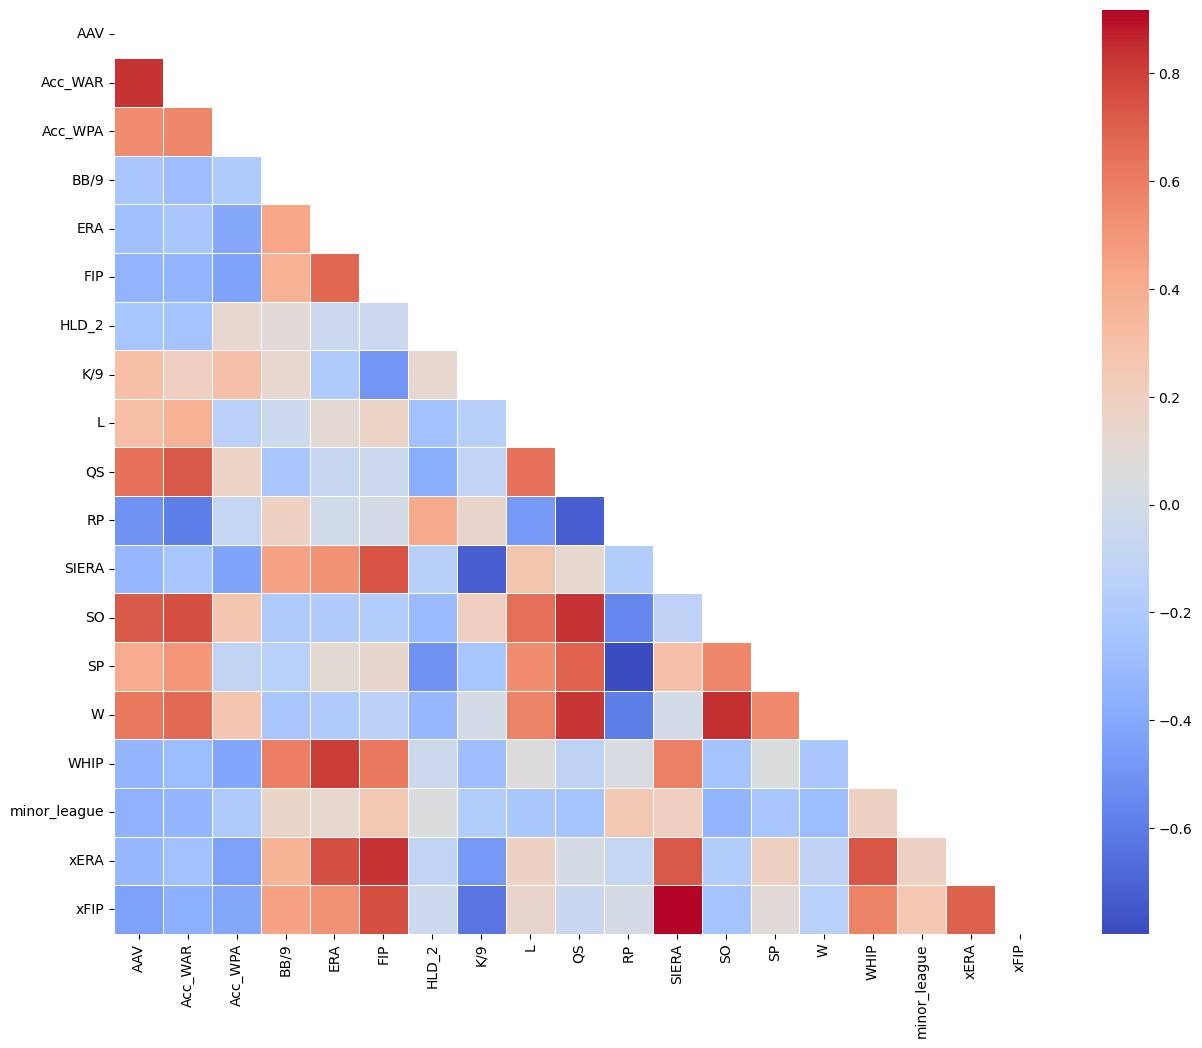

In [66]:
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(15, 12))


sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', fmt='.2f', linewidths=.5, ax=ax)

plt.show()

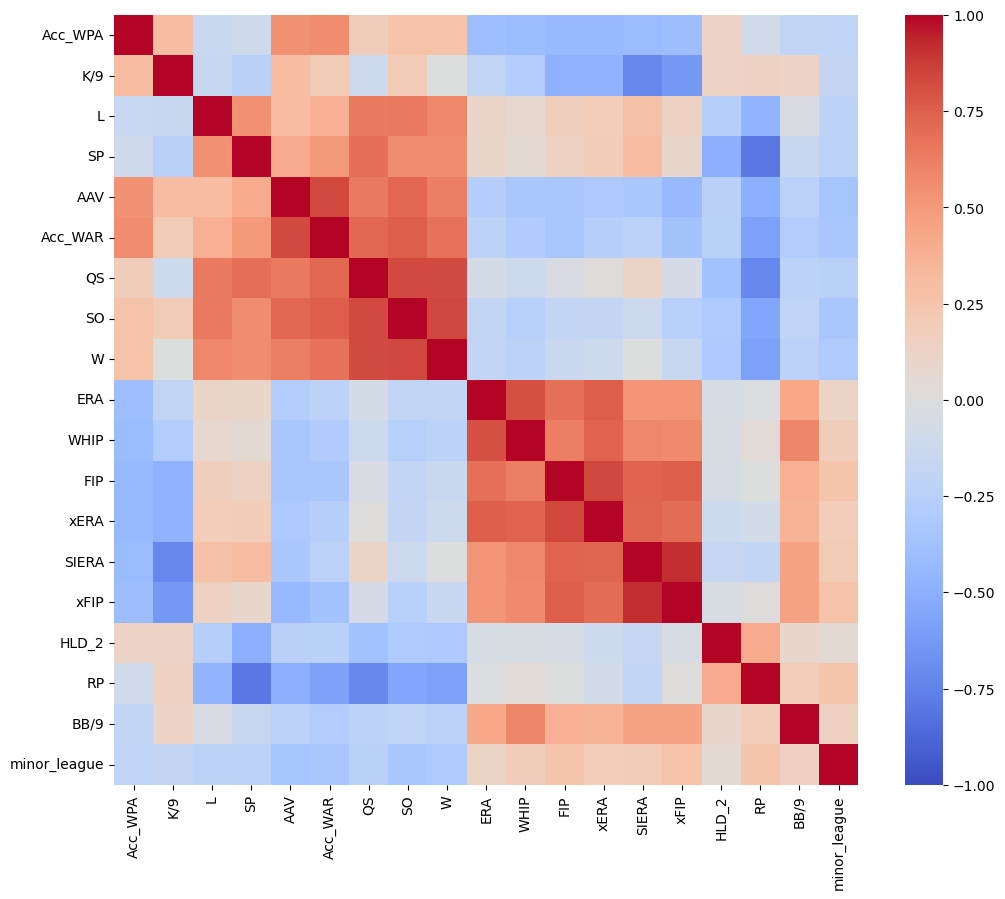

In [67]:
from scipy.cluster.hierarchy import linkage, dendrogram

linked = linkage(correlation_matrix, method='ward')

dendro = dendrogram(linked, no_plot=True)
reordered_corr_matrix = correlation_matrix.iloc[dendro['leaves'], dendro['leaves']]

plt.figure(figsize=(12, 10))

sns.heatmap(reordered_corr_matrix, annot=False, cmap="coolwarm", vmin=-1, vmax=1)

plt.savefig('corr_matrix_clustered.png')

plt.show()


In [68]:
target = "AAV"
feat = [col for col in df2.columns if col != target and col!= "Name"]
X, y = df2[feat], df2[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (406, 18)
X_test shape: (102, 18)
y_train shape: (406,)
y_test shape: (102,)


In [69]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [70]:
linear_y_pred = linear_model.predict(X_test)

results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = linear_y_pred
results_df["err"] = results_df["y_real"] - results_df["y_pred"]
results_df["%_err"] = results_df["err"] / results_df["y_real"] * 100
results_df

,minor_league,SP,RP,W,L,ERA,WHIP,QS,SO,K/9,...,FIP,xFIP,SIERA,xERA,Acc_WAR,Acc_WPA,y_real,y_pred,err,%_err
444,True,False,True,1,1,5.094341,1.556604,0,23,5.858492,...,4.685942,5.580392,5.049976,6.53,0.019265,-1.224556,1.479137,-2.245398,3.724535,251.804632
344,False,True,False,2,2,4.940000,1.260000,0,33,9.580000,...,3.353980,3.640975,3.754773,5.51,0.872343,-0.479032,4.160566,4.157000,0.003567,0.085723
47,False,False,True,7,2,3.281768,1.193370,0,80,11.933703,...,4.630731,4.335722,3.903878,4.51,-0.332473,-0.449046,4.500000,4.845328,-0.345328,-7.673958
67,False,False,True,2,2,3.375000,1.243421,0,64,11.368422,...,4.202409,3.259263,3.337010,3.71,-0.194070,-0.170446,6.000000,5.170947,0.829053,13.817542
363,False,True,True,7,9,3.570000,1.290000,11,169,8.880000,...,3.872494,4.069622,4.195858,4.12,1.432180,-2.293026,8.321133,8.152676,0.168457,2.024450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,False,True,True,12,8,2.890000,1.260000,23,169,7.750000,...,3.265232,3.803613,4.076585,3.59,4.649118,1.430136,19.536665,16.474248,3.062418,15.675232
224,False,False,True,3,2,2.138614,1.009901,0,36,9.623764,...,2.011618,3.688636,3.579097,3.03,1.898215,0.334268,1.371416,4.696237,-3.324821,-242.437173
110,False,True,False,7,8,3.470220,1.194357,5,91,7.702195,...,4.231553,4.182750,4.060422,4.17,1.612395,0.653820,9.445207,7.271220,2.173987,23.016832
428,False,False,True,3,6,3.610466,1.151163,0,70,10.988375,...,3.715779,4.052163,3.527367,3.17,2.181372,3.269964,16.566334,9.444242,7.122092,42.991357


In [71]:
print(f"RMSE: {mean_squared_error(y_test, linear_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, linear_y_pred)}")
print(f"R^2: {r2_score(y_test, linear_y_pred)}")

RMSE: 3.605773951885169
MAPE: 0.6331895142181011
R^2: 0.6168663825765277


In [72]:
negative_values_exist = (results_df["y_pred"] < 0).any()

if negative_values_exist:
    print("There are negative values in the 'y_pred' column.")
else:
    print("There are no negative values in the 'y_pred' column.")

There are negative values in the 'y_pred' column.


In [73]:
linear_model = LinearRegression()

y_train_log = np.log(y_train)
linear_model.fit(X_train, y_train_log)

linear_y_pred_log = linear_model.predict(X_test)


linear_y_pred = np.exp(linear_y_pred_log)

results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = linear_y_pred
results_df["err"] = results_df["y_real"] - results_df["y_pred"]
results_df["%_err"] = results_df["err"] / results_df["y_real"] * 100
results_df

,minor_league,SP,RP,W,L,ERA,WHIP,QS,SO,K/9,...,FIP,xFIP,SIERA,xERA,Acc_WAR,Acc_WPA,y_real,y_pred,err,%_err
444,True,False,True,1,1,5.094341,1.556604,0,23,5.858492,...,4.685942,5.580392,5.049976,6.53,0.019265,-1.224556,1.479137,0.640798,0.838339,56.677598
344,False,True,False,2,2,4.940000,1.260000,0,33,9.580000,...,3.353980,3.640975,3.754773,5.51,0.872343,-0.479032,4.160566,3.871723,0.288843,6.942406
47,False,False,True,7,2,3.281768,1.193370,0,80,11.933703,...,4.630731,4.335722,3.903878,4.51,-0.332473,-0.449046,4.500000,3.844076,0.655924,14.576088
67,False,False,True,2,2,3.375000,1.243421,0,64,11.368422,...,4.202409,3.259263,3.337010,3.71,-0.194070,-0.170446,6.000000,3.823040,2.176960,36.282661
363,False,True,True,7,9,3.570000,1.290000,11,169,8.880000,...,3.872494,4.069622,4.195858,4.12,1.432180,-2.293026,8.321133,5.374677,2.946456,35.409314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,False,True,True,12,8,2.890000,1.260000,23,169,7.750000,...,3.265232,3.803613,4.076585,3.59,4.649118,1.430136,19.536665,8.757258,10.779407,55.175268
224,False,False,True,3,2,2.138614,1.009901,0,36,9.623764,...,2.011618,3.688636,3.579097,3.03,1.898215,0.334268,1.371416,3.614770,-2.243354,-163.579459
110,False,True,False,7,8,3.470220,1.194357,5,91,7.702195,...,4.231553,4.182750,4.060422,4.17,1.612395,0.653820,9.445207,7.642768,1.802440,19.083113
428,False,False,True,3,6,3.610466,1.151163,0,70,10.988375,...,3.715779,4.052163,3.527367,3.17,2.181372,3.269964,16.566334,6.857068,9.709265,58.608414


In [74]:
print(f"RMSE: {mean_squared_error(y_test, linear_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, linear_y_pred)}")
print(f"R^2: {r2_score(y_test, linear_y_pred)}")

RMSE: 4.417517664976832
MAPE: 0.4592927303296637
R^2: 0.4249443752994905


## Ridge Regression

In [75]:
from sklearn.linear_model import Ridge

ridge_model = Ridge()

ridge_model.fit(X_train, y_train)

ridge_y_pred = ridge_model.predict(X_test)

results_df_ridge = X_test.copy()
results_df_ridge["y_real"] = y_test
results_df_ridge["y_pred"] = ridge_y_pred
results_df_ridge["err"] = results_df_ridge["y_real"] - results_df_ridge["y_pred"]
results_df_ridge["%_err"] = results_df_ridge["err"] / results_df_ridge["y_real"] * 100

results_df_ridge

,minor_league,SP,RP,W,L,ERA,WHIP,QS,SO,K/9,...,FIP,xFIP,SIERA,xERA,Acc_WAR,Acc_WPA,y_real,y_pred,err,%_err
444,True,False,True,1,1,5.094341,1.556604,0,23,5.858492,...,4.685942,5.580392,5.049976,6.53,0.019265,-1.224556,1.479137,-2.243196,3.722333,251.655738
344,False,True,False,2,2,4.940000,1.260000,0,33,9.580000,...,3.353980,3.640975,3.754773,5.51,0.872343,-0.479032,4.160566,4.136282,0.024285,0.583684
47,False,False,True,7,2,3.281768,1.193370,0,80,11.933703,...,4.630731,4.335722,3.903878,4.51,-0.332473,-0.449046,4.500000,4.822782,-0.322782,-7.172940
67,False,False,True,2,2,3.375000,1.243421,0,64,11.368422,...,4.202409,3.259263,3.337010,3.71,-0.194070,-0.170446,6.000000,5.195021,0.804979,13.416312
363,False,True,True,7,9,3.570000,1.290000,11,169,8.880000,...,3.872494,4.069622,4.195858,4.12,1.432180,-2.293026,8.321133,8.185819,0.135314,1.626147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,False,True,True,12,8,2.890000,1.260000,23,169,7.750000,...,3.265232,3.803613,4.076585,3.59,4.649118,1.430136,19.536665,16.479932,3.056733,15.646137
224,False,False,True,3,2,2.138614,1.009901,0,36,9.623764,...,2.011618,3.688636,3.579097,3.03,1.898215,0.334268,1.371416,4.721220,-3.349805,-244.258895
110,False,True,False,7,8,3.470220,1.194357,5,91,7.702195,...,4.231553,4.182750,4.060422,4.17,1.612395,0.653820,9.445207,7.252817,2.192390,23.211667
428,False,False,True,3,6,3.610466,1.151163,0,70,10.988375,...,3.715779,4.052163,3.527367,3.17,2.181372,3.269964,16.566334,9.414455,7.151879,43.171162


In [76]:
print(f"RMSE: {mean_squared_error(y_test, ridge_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, ridge_y_pred)}")
print(f"R^2: {r2_score(y_test, ridge_y_pred)}")

RMSE: 3.605721807905695
MAPE: 0.6313301757315732
R^2: 0.6168774636743976


In [77]:
negative_values_exist = (results_df_ridge["y_pred"] < 0).any()

if negative_values_exist:
    print("There are negative values in the 'y_pred' column.")
else:
    print("There are no negative values in the 'y_pred' column.")

There are negative values in the 'y_pred' column.


In [78]:
y_train_log = np.log(y_train)


ridge_model = Ridge()
ridge_model.fit(X_train, y_train_log)


ridge_y_pred_log = ridge_model.predict(X_test)


ridge_y_pred = np.exp(ridge_y_pred_log)

rmse = np.sqrt(mean_squared_error(y_test, ridge_y_pred))
r2 = r2_score(y_test, ridge_y_pred)
mape = np.mean(np.abs((y_test - ridge_y_pred) / y_test)) 

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"R^2: {r2}")


results_df_ridge = X_test.copy()
results_df_ridge["y_real"] = y_test
results_df_ridge["y_pred"] = ridge_y_pred
results_df_ridge["err"] = results_df_ridge["y_real"] - results_df_ridge["y_pred"]
results_df_ridge["%_err"] = results_df_ridge["err"] / results_df_ridge["y_real"] * 100

results_df_ridge

RMSE: 4.417430612077288
MAPE: 0.45976572489955647
R^2: 0.424967039505986


,minor_league,SP,RP,W,L,ERA,WHIP,QS,SO,K/9,...,FIP,xFIP,SIERA,xERA,Acc_WAR,Acc_WPA,y_real,y_pred,err,%_err
444,True,False,True,1,1,5.094341,1.556604,0,23,5.858492,...,4.685942,5.580392,5.049976,6.53,0.019265,-1.224556,1.479137,0.648356,0.830781,56.166582
344,False,True,False,2,2,4.940000,1.260000,0,33,9.580000,...,3.353980,3.640975,3.754773,5.51,0.872343,-0.479032,4.160566,3.862335,0.298232,7.168051
47,False,False,True,7,2,3.281768,1.193370,0,80,11.933703,...,4.630731,4.335722,3.903878,4.51,-0.332473,-0.449046,4.500000,3.833768,0.666232,14.805154
67,False,False,True,2,2,3.375000,1.243421,0,64,11.368422,...,4.202409,3.259263,3.337010,3.71,-0.194070,-0.170446,6.000000,3.809326,2.190674,36.511239
363,False,True,True,7,9,3.570000,1.290000,11,169,8.880000,...,3.872494,4.069622,4.195858,4.12,1.432180,-2.293026,8.321133,5.398431,2.922702,35.123847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,False,True,True,12,8,2.890000,1.260000,23,169,7.750000,...,3.265232,3.803613,4.076585,3.59,4.649118,1.430136,19.536665,8.806593,10.730072,54.922740
224,False,False,True,3,2,2.138614,1.009901,0,36,9.623764,...,2.011618,3.688636,3.579097,3.03,1.898215,0.334268,1.371416,3.625375,-2.253960,-164.352777
110,False,True,False,7,8,3.470220,1.194357,5,91,7.702195,...,4.231553,4.182750,4.060422,4.17,1.612395,0.653820,9.445207,7.602858,1.842349,19.505648
428,False,False,True,3,6,3.610466,1.151163,0,70,10.988375,...,3.715779,4.052163,3.527367,3.17,2.181372,3.269964,16.566334,6.843568,9.722766,58.689908


In [79]:
print(f"RMSE: {mean_squared_error(y_test, ridge_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, ridge_y_pred)}")
print(f"R^2: {r2_score(y_test, ridge_y_pred)}")

RMSE: 4.417430612077288
MAPE: 0.45976572489955647
R^2: 0.424967039505986


## XGBoost Regression

In [80]:
xgb_model = XGBRegressor()

xgb_model.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)

results_df_xgb = X_test.copy()
results_df_xgb["y_real"] = y_test
results_df_xgb["y_pred"] = xgb_y_pred
results_df_xgb["err"] = results_df_xgb["y_real"] - results_df_xgb["y_pred"]
results_df_xgb["%_err"] = results_df_xgb["err"] / results_df_xgb["y_real"] * 100


results_df_xgb

,minor_league,SP,RP,W,L,ERA,WHIP,QS,SO,K/9,...,FIP,xFIP,SIERA,xERA,Acc_WAR,Acc_WPA,y_real,y_pred,err,%_err
444,True,False,True,1,1,5.094341,1.556604,0,23,5.858492,...,4.685942,5.580392,5.049976,6.53,0.019265,-1.224556,1.479137,1.037730,0.441407,29.842180
344,False,True,False,2,2,4.940000,1.260000,0,33,9.580000,...,3.353980,3.640975,3.754773,5.51,0.872343,-0.479032,4.160566,3.237996,0.922571,22.174158
47,False,False,True,7,2,3.281768,1.193370,0,80,11.933703,...,4.630731,4.335722,3.903878,4.51,-0.332473,-0.449046,4.500000,5.379490,-0.879490,-19.544231
67,False,False,True,2,2,3.375000,1.243421,0,64,11.368422,...,4.202409,3.259263,3.337010,3.71,-0.194070,-0.170446,6.000000,4.710851,1.289149,21.485813
363,False,True,True,7,9,3.570000,1.290000,11,169,8.880000,...,3.872494,4.069622,4.195858,4.12,1.432180,-2.293026,8.321133,12.461605,-4.140472,-49.758515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,False,True,True,12,8,2.890000,1.260000,23,169,7.750000,...,3.265232,3.803613,4.076585,3.59,4.649118,1.430136,19.536665,16.773336,2.763329,14.144322
224,False,False,True,3,2,2.138614,1.009901,0,36,9.623764,...,2.011618,3.688636,3.579097,3.03,1.898215,0.334268,1.371416,6.601008,-5.229593,-381.328071
110,False,True,False,7,8,3.470220,1.194357,5,91,7.702195,...,4.231553,4.182750,4.060422,4.17,1.612395,0.653820,9.445207,9.549487,-0.104280,-1.104052
428,False,False,True,3,6,3.610466,1.151163,0,70,10.988375,...,3.715779,4.052163,3.527367,3.17,2.181372,3.269964,16.566334,12.038360,4.527974,27.332384


In [81]:
print(f"RMSE: {mean_squared_error(y_test, xgb_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, xgb_y_pred)}")
print(f"R^2: {r2_score(y_test, xgb_y_pred)}")

RMSE: 4.105939878928246
MAPE: 0.515628769564871
R^2: 0.5032036025530371


In [82]:
negative_values_exist = (results_df_xgb["y_pred"] < 0).any()

if negative_values_exist:
    print("There are negative values in the 'y_pred' column.")
else:
    print("There are no negative values in the 'y_pred' column.")

There are no negative values in the 'y_pred' column.
